This subject of this project is the housing crisis in Ireland.
- Is this also the case in other countries within the UK & Ireland?
- Is housing increasing or decreasing in line with population growth?
- Will current trends in houses being built be able to accomodate the population over time?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import glob
from copy import deepcopy

In [3]:
import requests
import json
import xml.etree.ElementTree as ET

In [4]:
import warnings

# turn off slice warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]

# Data Ingestion

## IE Data First
This will later be replaced by mongodb calls using json versions of this data.

In [6]:
# https://data.gov.ie/dataset/ndq01-new-dwelling-completions/resource/8fdc8f87-88ca-43f7-aa16-dbc3a52cacde
df_ie_ndq1_orig = pd.read_csv('./datasets/ie/NDQ01.csv')

# https://data.gov.ie/dataset/ndq03-new-dwelling-completions/resource/45701f7f-1192-406f-980f-a8ee23862147
df_ie_ndq3_orig = pd.read_csv('./datasets/ie/NDQ03.csv')

# https://data.gov.ie/dataset/ndq05-new-dwelling-completion/resource/108d82d0-43f1-4574-9e47-bb54f078fd84
df_ie_ndq5_orig = pd.read_csv('./datasets/ie/NDQ05.csv')

# https://data.gov.ie/dataset/ndq06-new-dwelling-completion/resource/0b5041bb-9f52-4b54-8c8d-0000306e74e2
df_ie_ndq6_orig = pd.read_csv('./datasets/ie/NDQ06.csv')

# UK data

In [7]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/ukhousebuildingpermanentdwellingsstartedandcompleted
df_uk_con_output_orig = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx')

# Population data

# Data Cleansing & Preparation

# IE functions

In [8]:
def extract_year_and_qtr(df, qtr_col_name):
    """
    Add docstring
    """
    
    df['year'] = df[qtr_col_name].str[:4].astype('int64')
    df['qtr'] = df[qtr_col_name].str[-2:]
    return df

## IE Data

In [9]:
df_ie_ndq1 = deepcopy(df_ie_ndq1_orig)

In [10]:
df_ie_ndq1.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,UNIT,VALUE
0,NDQ01,New Dwelling Completions,20111,2011Q1,06,Single house,Number,1156
1,NDQ01,New Dwelling Completions,20111,2011Q1,07,Scheme house,Number,447
2,NDQ01,New Dwelling Completions,20111,2011Q1,08,Apartment,Number,272
3,NDQ01,New Dwelling Completions,20111,2011Q1,-,All house types,Number,1875
4,NDQ01,New Dwelling Completions,20112,2011Q2,06,Single house,Number,1194


In [11]:
df_ie_ndq1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   UNIT             392 non-null    object
 7   VALUE            392 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 24.6+ KB


In [12]:
df_ie_ndq1 = extract_year_and_qtr(df_ie_ndq1, 'Quarter')

In [13]:
df_ie_ndq1['STATISTIC Label'].unique()

array(['New Dwelling Completions',
       'Seasonally Adjusted New Dwelling Completions'], dtype=object)

In [14]:
# Statistic & Statistic Label represent the same data, so we can drop STATISTC and keep the label
df_ie_ndq1.pivot_table(index='STATISTIC Label',  columns='STATISTIC', values='VALUE', aggfunc='sum')

STATISTIC,NDQ01,NDQ01C02
STATISTIC Label,,
New Dwelling Completions,339994.0,NaN
Seasonally Adjusted New Dwelling Completions,NaN,340507.0


<Axes: xlabel='year', ylabel='VALUE'>

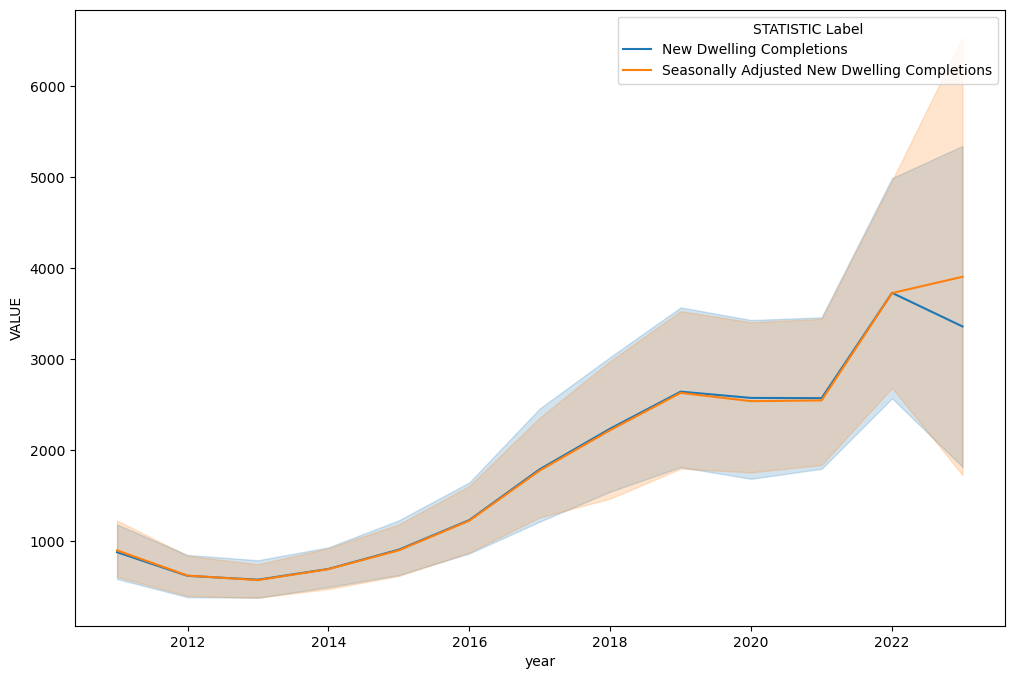

In [15]:
sns.lineplot(data=df_ie_ndq1, x='year', y='VALUE', hue='STATISTIC Label')

In [16]:
df_ie_ndq1.groupby(['STATISTIC Label'])['VALUE'].sum()

STATISTIC Label
New Dwelling Completions                        339994
Seasonally Adjusted New Dwelling Completions    340507
Name: VALUE, dtype: int64

In [17]:
df_ie_ndq1 = df_ie_ndq1[df_ie_ndq1['STATISTIC Label'] == 'New Dwelling Completions']

In [18]:
# Type of House is mapped to C02342V02816, so we can drop C02342V02816.
df_ie_ndq1.pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0)

C02342V02816,-,06,07,08
Type of House,,,,
All house types,169997,0,0,0
Apartment,0,0,0,32826
Scheme house,0,0,85622,0
Single house,0,51549,0,0


In [19]:
# The sum of Apartment, Scheme house and Single house equals All house types
df_ie_ndq1[df_ie_ndq1['Type of House']!='All house types'].pivot_table(index='Type of House',  columns='C02342V02816', values='VALUE', aggfunc='sum', fill_value=0).sum().sum()

169997

In [20]:
df_ie_ndq1['type_comp'] = df_ie_ndq1['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [21]:
df_ndq1_temp = df_ie_ndq1.pivot_table(index='Quarter',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq1_temp.head()

type_comp,All,All house types
Quarter,,
2011Q1,1875,1875
2011Q2,1791,1791
2011Q3,1687,1687
2011Q4,1641,1641
2012Q1,1131,1131


In [22]:
df_ndq1_temp['diff'] = df_ndq1_temp['All'] - df_ndq1_temp['All house types']
df_ndq1_temp[df_ndq1_temp['diff'] != 0]

type_comp,All,All house types,diff
Quarter,,,


In [23]:
assert((df_ndq1_temp['All'] == df_ndq1_temp['All house types']).all())

In [24]:
# UNIT is an unnecessary column as there is just a single value 'Number'.
df_ie_ndq1.pivot_table(index='UNIT',  columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0)

Type of House,All house types,Apartment,Scheme house,Single house
UNIT,,,,
Number,169997,32826,85622,51549


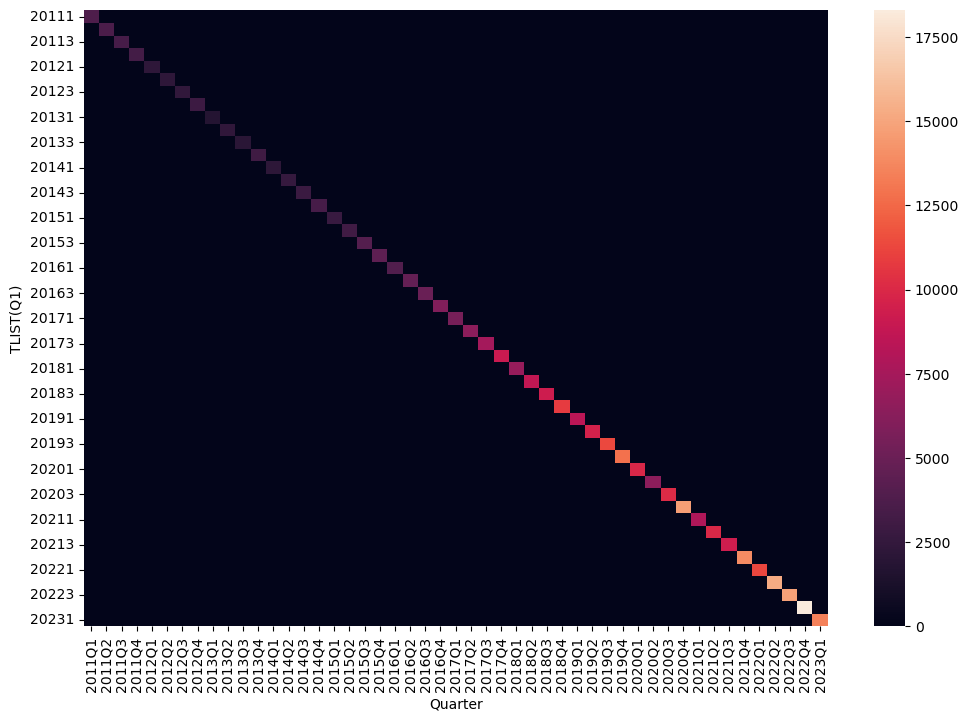

In [25]:
# TLIST(Q1) appears to be the same as Quarter
df_qtr_pivot = df_ie_ndq1.pivot_table(index='TLIST(Q1)',  columns='Quarter', values='VALUE', aggfunc='sum', fill_value=0)
sns.heatmap(df_qtr_pivot)
plt.show()

In [26]:
# Test that all the values in TLIST(Q1) are the same as in Quarter but with an added Q in the second last position
assert((df_ie_ndq1['Quarter'].str.replace('Q', '').astype('str') == df_ie_ndq1['TLIST(Q1)'].astype('str')).all())

In [27]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'UNIT', 'type_comp']

In [28]:
df_ie_ndq1_clean = df_ie_ndq1.drop(list_cols_to_drop, axis=1)

In [29]:
df_ie_ndq1_clean.head()

,STATISTIC Label,Quarter,Type of House,VALUE,year,qtr
0,New Dwelling Completions,2011Q1,Single house,1156,2011,Q1
1,New Dwelling Completions,2011Q1,Scheme house,447,2011,Q1
2,New Dwelling Completions,2011Q1,Apartment,272,2011,Q1
3,New Dwelling Completions,2011Q1,All house types,1875,2011,Q1
4,New Dwelling Completions,2011Q2,Single house,1194,2011,Q2


What is the difference between New & Seasonally adjusted?  
Looks like seasonally adjusted has some applied logic where New is the raw numbers.  
- For now focus on new until I can justify the selection.

In [30]:
# I don't think I'll end up needing this but keep it for now and decide when joining the dataframes.
df_ie_ndq1_pivot = df_ie_ndq1_clean.pivot_table(index=['Quarter', 'year', 'qtr'], columns='Type of House', values='VALUE', aggfunc='sum', fill_value=0).reset_index()

In [31]:
df_ie_ndq1_pivot.head()

Type of House,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house
0,2011Q1,2011,Q1,1875,272,447,1156
1,2011Q2,2011,Q2,1791,217,380,1194
2,2011Q3,2011,Q3,1687,185,305,1197
3,2011Q4,2011,Q4,1641,148,226,1267
4,2012Q1,2012,Q1,1131,123,211,797


In [32]:
df_ie_ndq1_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Quarter          49 non-null     object
 1   year             49 non-null     int64 
 2   qtr              49 non-null     object
 3   All house types  49 non-null     int64 
 4   Apartment        49 non-null     int64 
 5   Scheme house     49 non-null     int64 
 6   Single house     49 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.8+ KB


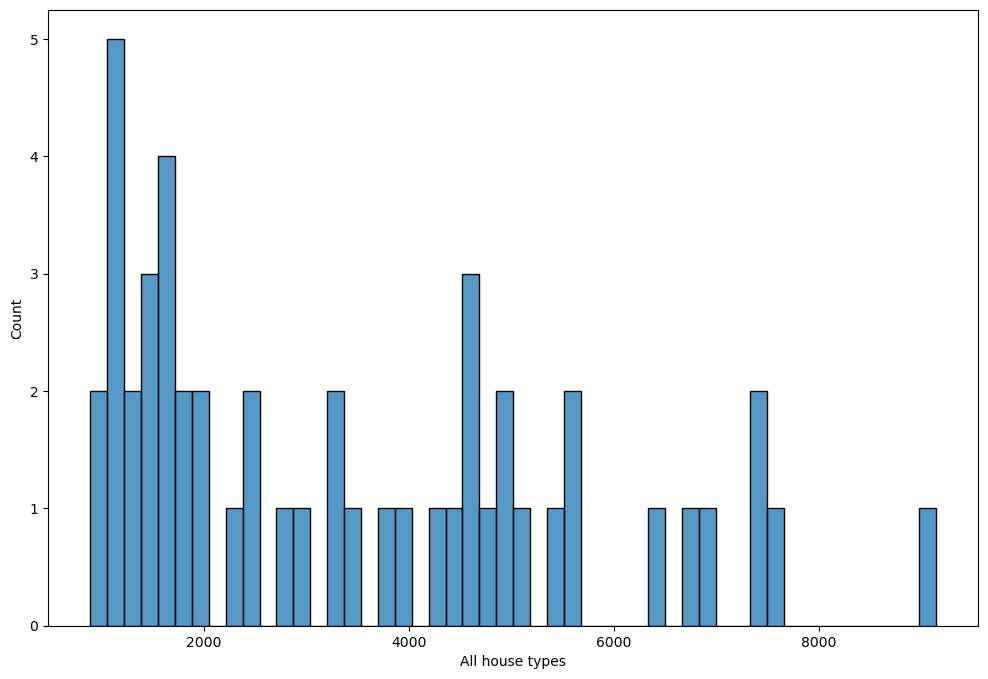

In [33]:
sns.histplot(data=df_ie_ndq1_pivot, x='All house types', bins=50)
plt.show()

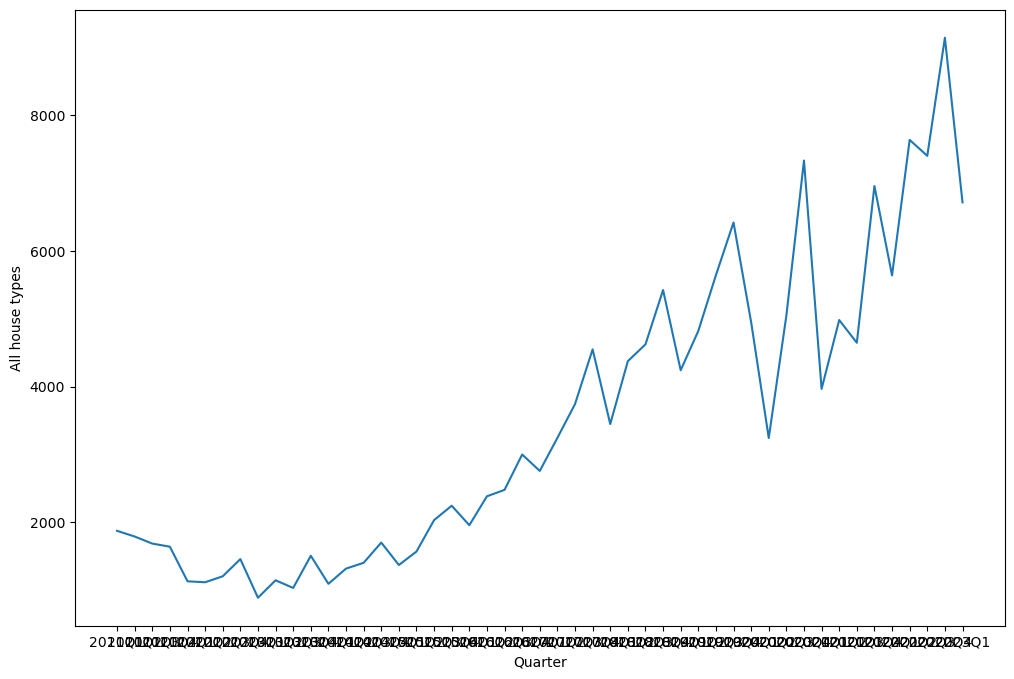

In [34]:
sns.lineplot(data=df_ie_ndq1_pivot, x='Quarter', y='All house types')
plt.show()

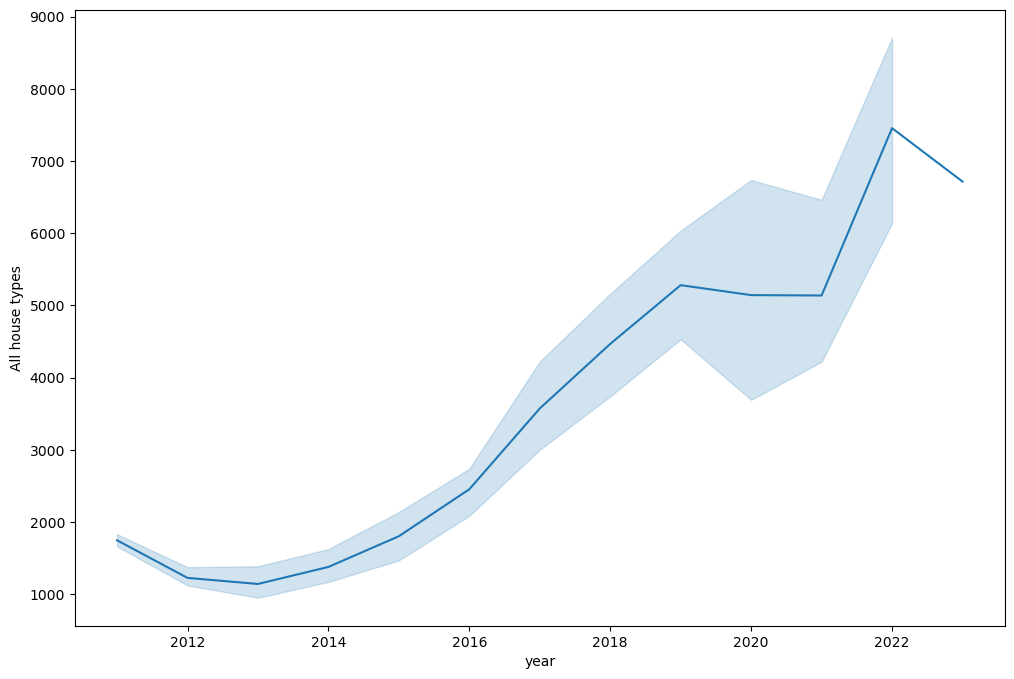

In [35]:
sns.lineplot(data=df_ie_ndq1_pivot, x='year', y='All house types')
plt.show()

Scheme houses took a sharp drop from 2019 to 2021 then a shrap rise and another sharp drop.  
- Could this be due to missing data or just is it a reflection of reality?
- Correction, this is due to COVID. (https://www.irishtimes.com/business/construction/over-20-000-new-homes-completed-in-2020-despite-covid-disruption-1.4476058)   
The downturn in Q2 & Q3 was across all segments but apartments recovered in Q4.  

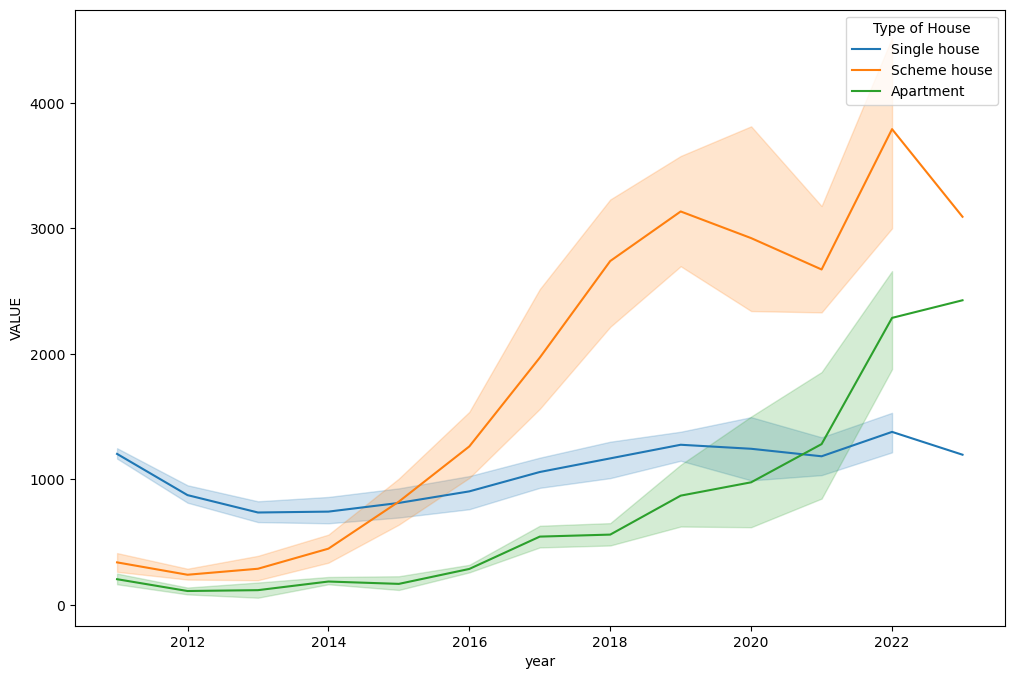

In [36]:
sns.lineplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House']!= 'All house types'],
                                                    x='year', y='VALUE', hue='Type of House')
plt.show()

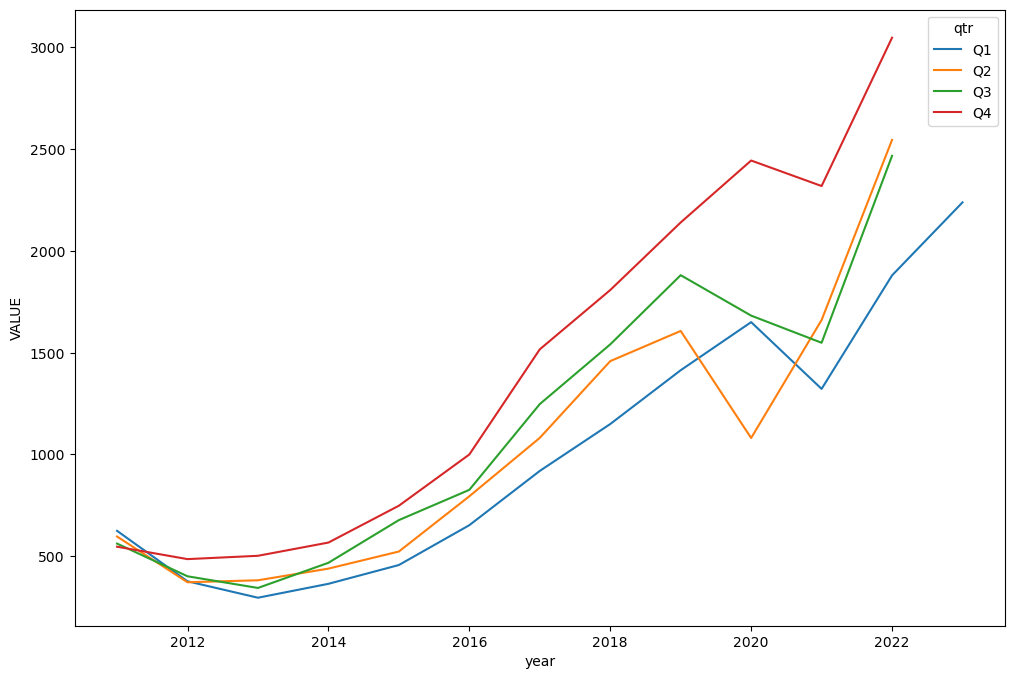

In [37]:
sns.lineplot(data=df_ie_ndq1_clean[df_ie_ndq1_clean['Type of House']!= 'All house types'],
                                                    x='year', y='VALUE', hue='qtr', errorbar=None)
plt.show()

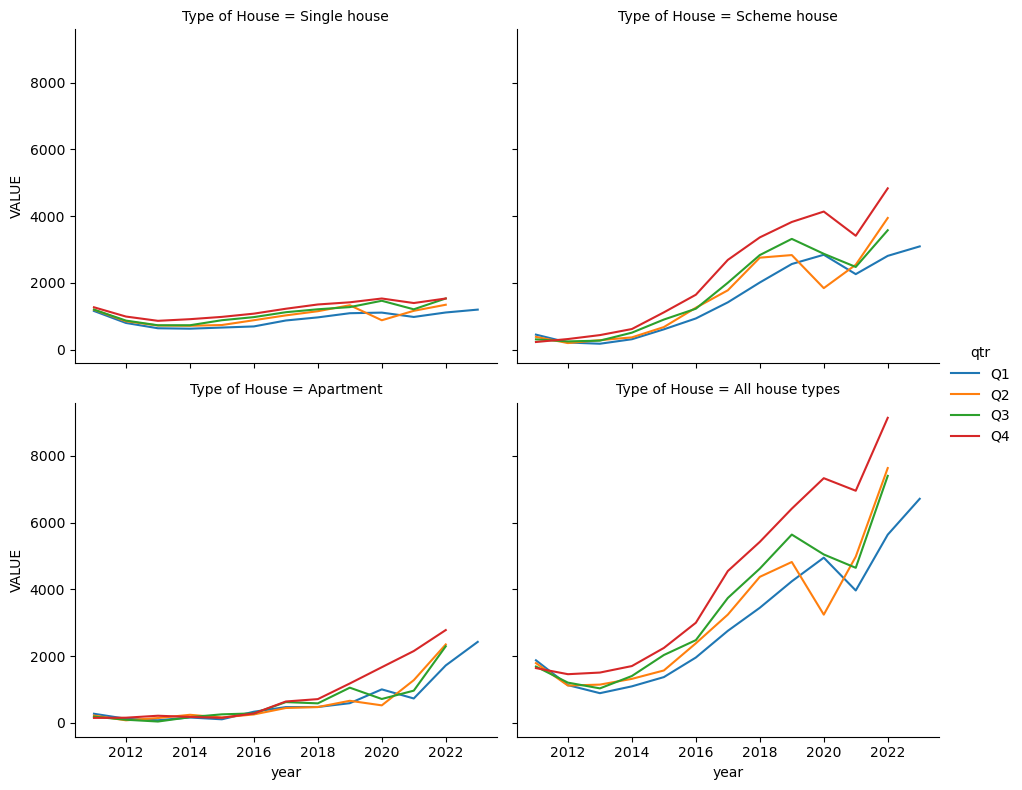

In [38]:
sns.relplot(data=df_ie_ndq1_clean, kind='line', x='year', y='VALUE', hue='qtr',
            col='Type of House', col_wrap=2, height=4, aspect=1.2, legend=True)
plt.show()

In [39]:
df_ndq1_house_totals = df_ie_ndq1_clean.groupby(['Type of House'])['VALUE'].sum()

## IE DF no.2

In [40]:
df_ie_ndq3 = deepcopy(df_ie_ndq3_orig)

In [41]:
df_ie_ndq3.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C02106V02545,Urban and Rural,UNIT,VALUE
0,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,1,Urban areas,Number,841
1,NDQ03,New Dwelling Completions,20111,2011Q1,-,All house types,5,Rural areas,Number,1033
2,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,1,Urban areas,Number,152
3,NDQ03,New Dwelling Completions,20111,2011Q1,06,Single house,5,Rural areas,Number,1004
4,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,1,Urban areas,Number,422
5,NDQ03,New Dwelling Completions,20111,2011Q1,07,Scheme house,5,Rural areas,Number,25
6,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,1,Urban areas,Number,267
7,NDQ03,New Dwelling Completions,20111,2011Q1,08,Apartment,5,Rural areas,Number,4
8,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,1,Urban areas,Number,706
9,NDQ03,New Dwelling Completions,20112,2011Q2,-,All house types,5,Rural areas,Number,1081


In [42]:
df_ie_ndq3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        392 non-null    object
 1   STATISTIC Label  392 non-null    object
 2   TLIST(Q1)        392 non-null    int64 
 3   Quarter          392 non-null    object
 4   C02342V02816     392 non-null    object
 5   Type of House    392 non-null    object
 6   C02106V02545     392 non-null    int64 
 7   Urban and Rural  392 non-null    object
 8   UNIT             392 non-null    object
 9   VALUE            392 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 30.8+ KB


In [43]:
df_ie_ndq3 = extract_year_and_qtr(df_ie_ndq3, 'Quarter')

In [44]:
# Check if all house types is equal to the sum of urban and rural areas
df_ie_ndq3['type_comp'] = df_ie_ndq3['Type of House'].apply(lambda x: 'All' if x != "All house types" else x)

In [45]:
df_ndq3_temp = df_ie_ndq3.pivot_table(index=['Quarter', 'Urban and Rural'],  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)
df_ndq3_temp.head()

type_comp                 All  All house types
Quarter Urban and Rural                       
2011Q1  Rural areas      1033             1033
        Urban areas       841              841
2011Q2  Rural areas      1081             1081
        Urban areas       706              706
2011Q3  Rural areas      1085             1085

In [46]:
df_ndq3_temp['diff'] = df_ndq3_temp['All'] - df_ndq3_temp['All house types']
df_ndq3_temp

type_comp                 All  All house types  diff
Quarter Urban and Rural                             
2011Q1  Rural areas      1033             1033     0
        Urban areas       841              841     0
2011Q2  Rural areas      1081             1081     0
        Urban areas       706              706     0
2011Q3  Rural areas      1085             1085     0
...                       ...              ...   ...
2022Q3  Urban areas      6087             6087     0
2022Q4  Rural areas      1339             1339     0
        Urban areas      7804             7804     0
2023Q1  Rural areas       967              967     0
        Urban areas      5749             5749     0

[98 rows x 3 columns]

In [47]:
df_ndq3_temp[df_ndq3_temp['diff']==0]

type_comp                 All  All house types  diff
Quarter Urban and Rural                             
2011Q1  Rural areas      1033             1033     0
        Urban areas       841              841     0
2011Q2  Rural areas      1081             1081     0
        Urban areas       706              706     0
2011Q3  Rural areas      1085             1085     0
...                       ...              ...   ...
2022Q3  Urban areas      6087             6087     0
2022Q4  Rural areas      1339             1339     0
        Urban areas      7804             7804     0
2023Q1  Rural areas       967              967     0
        Urban areas      5749             5749     0

[98 rows x 3 columns]

In [48]:
# Totals are equal
df_ie_ndq3.pivot_table(index='UNIT',  columns='type_comp', values='VALUE', aggfunc='sum', fill_value=0)

type_comp,All,All house types
UNIT,,
Number,169985,169985


In [49]:
df_ndq3_house_totals = df_ie_ndq3.groupby(['Type of House'])['VALUE'].sum()

In [50]:
# Approx half of each house type from ndq1 is included in ndq3 - including totals.
df_ndq3_temp = pd.concat([df_ndq1_house_totals, df_ndq3_house_totals], axis=1)
df_ndq3_temp.columns = ['ndq1', 'ndq3']
df_ndq3_temp['diff'] = df_ndq3_temp['ndq1'] - df_ndq3_temp['ndq3']
df_ndq3_temp['diff %'] = df_ndq3_temp['diff'] / df_ndq3_temp['ndq1']
print(df_ndq3_temp)

                   ndq1    ndq3  diff    diff %
Type of House                                  
All house types  169997  169985    12  0.000071
Apartment         32826   32819     7  0.000213
Scheme house      85622   85621     1  0.000012
Single house      51549   51545     4  0.000078


In [51]:
# Urban and Rural is mapped to C02106V02545, so we can drop C02106V02545.
df_ie_ndq3.pivot_table(index='Urban and Rural',  columns='C02106V02545', values='VALUE', aggfunc='sum', fill_value=0)

C02106V02545,1,5
Urban and Rural,,
Rural areas,0,87864
Urban areas,252106,0


In [52]:
# Add C02106V02545 to the existing drop_cols list as the other columns are also present.
list_cols_to_drop.append('C02106V02545')

In [53]:
df_ie_ndq3_clean = df_ie_ndq3.drop(list_cols_to_drop, axis=1)

In [54]:
df_ie_ndq3_clean['house_area'] = df_ie_ndq3_clean['Type of House'].str.strip() +"-"+ df_ie_ndq3_clean['Urban and Rural'].str.strip()


In [55]:
df_ie_ndq3_clean.head()

,STATISTIC Label,Quarter,Type of House,Urban and Rural,VALUE,year,qtr,house_area
0,New Dwelling Completions,2011Q1,All house types,Urban areas,841,2011,Q1,All house types-Urban areas
1,New Dwelling Completions,2011Q1,All house types,Rural areas,1033,2011,Q1,All house types-Rural areas
2,New Dwelling Completions,2011Q1,Single house,Urban areas,152,2011,Q1,Single house-Urban areas
3,New Dwelling Completions,2011Q1,Single house,Rural areas,1004,2011,Q1,Single house-Rural areas
4,New Dwelling Completions,2011Q1,Scheme house,Urban areas,422,2011,Q1,Scheme house-Urban areas


In [56]:
df_ie_ndq3_clean = df_ie_ndq3_clean[df_ie_ndq3_clean['Type of House']!='All house types']

In [57]:
df_ie_ndq3_pivot = df_ie_ndq3_clean.pivot_table(index=['Quarter'], columns=['house_area'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [58]:
df_ie_ndq3_pivot.head()

house_area,Quarter,Apartment-Rural areas,Apartment-Urban areas,Scheme house-Rural areas,Scheme house-Urban areas,Single house-Rural areas,Single house-Urban areas
0,2011Q1,4,267,25,422,1004,152
1,2011Q2,1,215,24,355,1056,136
2,2011Q3,0,185,37,268,1048,149
3,2011Q4,1,147,20,206,1131,136
4,2012Q1,5,118,12,199,699,98


In [59]:
df_ie_ndq3_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   Apartment-Rural areas     49 non-null     int64 
 2   Apartment-Urban areas     49 non-null     int64 
 3   Scheme house-Rural areas  49 non-null     int64 
 4   Scheme house-Urban areas  49 non-null     int64 
 5   Single house-Rural areas  49 non-null     int64 
 6   Single house-Urban areas  49 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 2.8+ KB


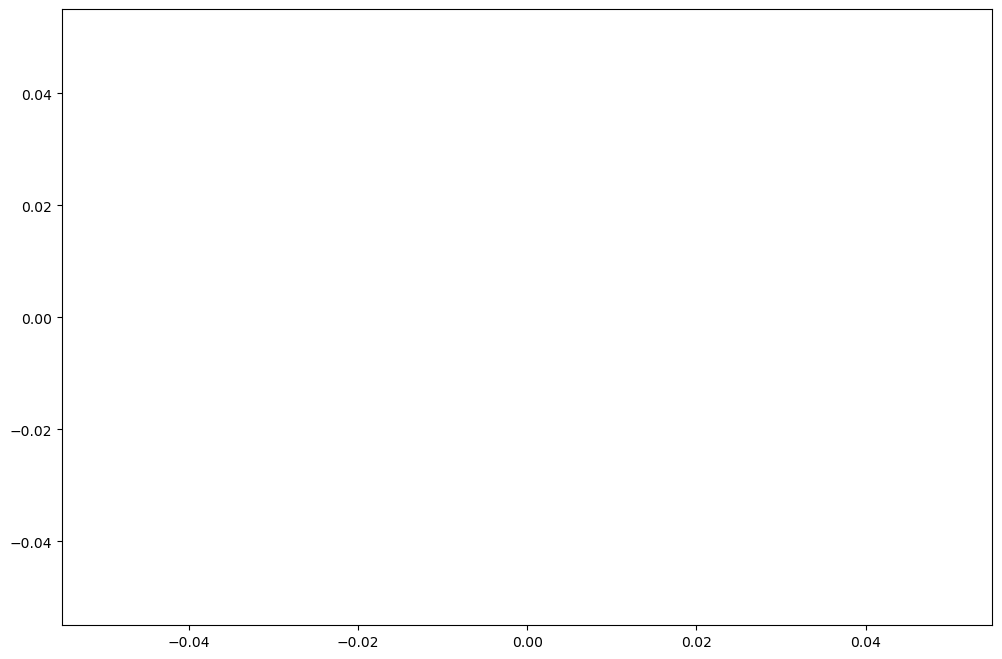

In [60]:
sns.histplot(data=df_ie_ndq3_clean[df_ie_ndq3_clean['Type of House'] == 'All house types'], x='VALUE')
plt.show()

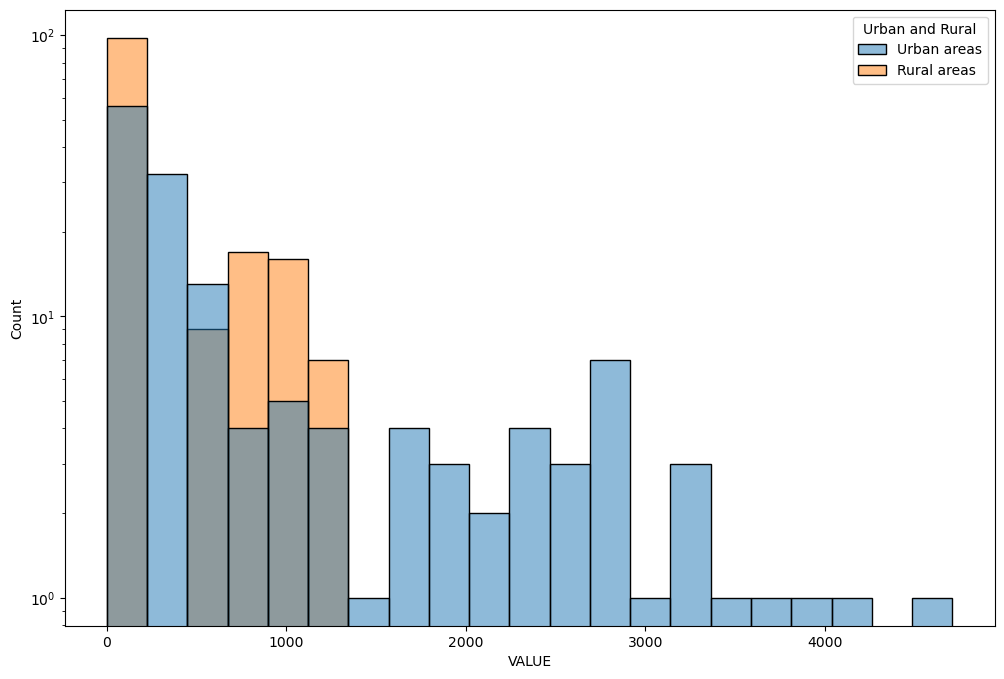

In [61]:
hp = sns.histplot(data=df_ie_ndq3_clean, 
             x='VALUE', hue='Urban and Rural', alpha=0.5)
hp.set_yscale('log')
plt.show()

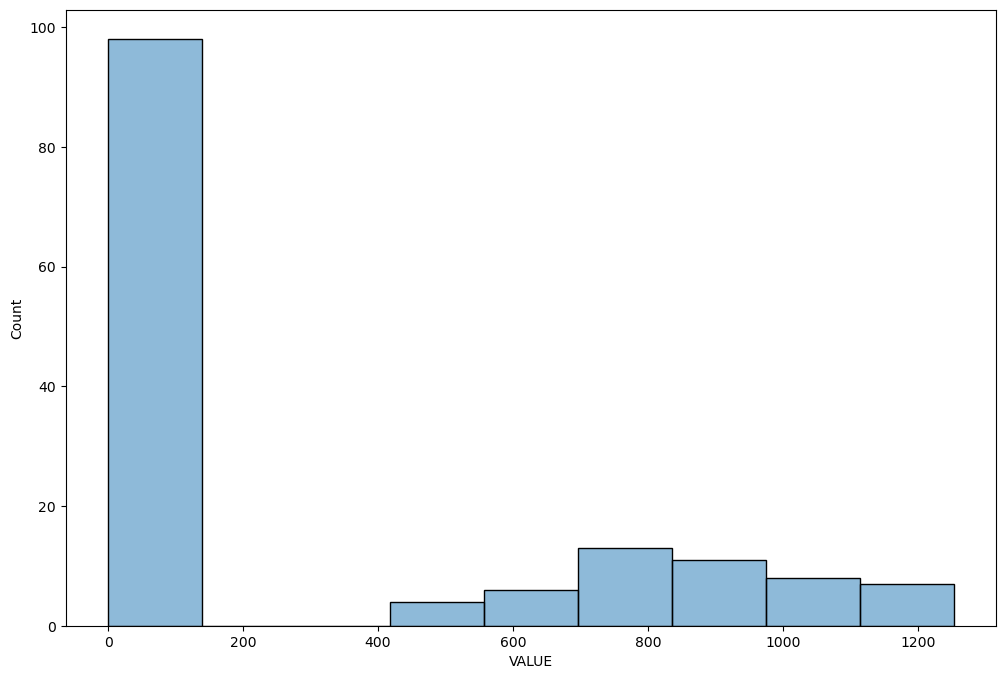

In [62]:
rural_df = df_ie_ndq3_clean[df_ie_ndq3_clean['Urban and Rural']=='Rural areas']
sns.histplot(data=rural_df, x='VALUE', alpha=0.5)
hp.set_yscale('log')

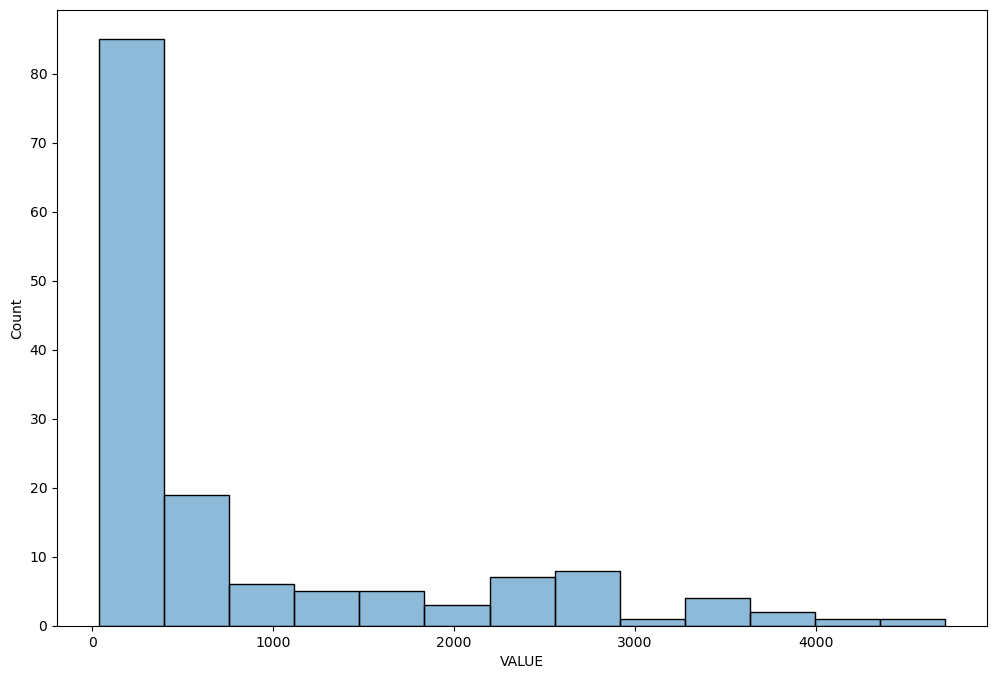

In [63]:
urban_df = df_ie_ndq3_clean[df_ie_ndq3_clean['Urban and Rural']=='Urban areas']
sns.histplot(data=urban_df, x='VALUE', alpha=0.5)
plt.show()

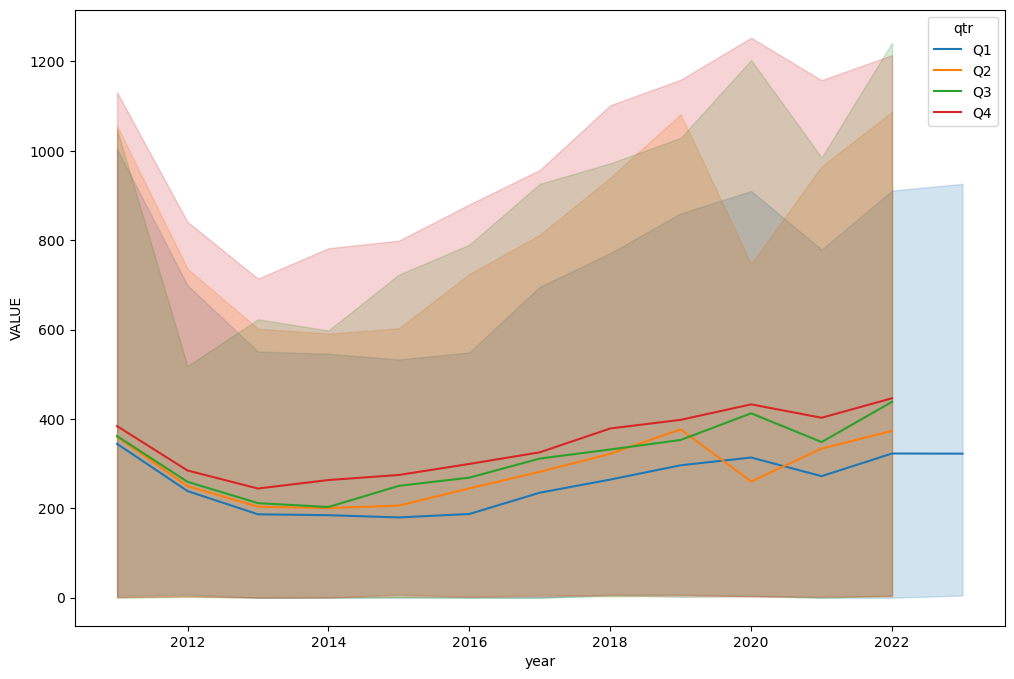

In [64]:
sns.lineplot(data=rural_df, x='year', y='VALUE', hue='qtr')
plt.show()

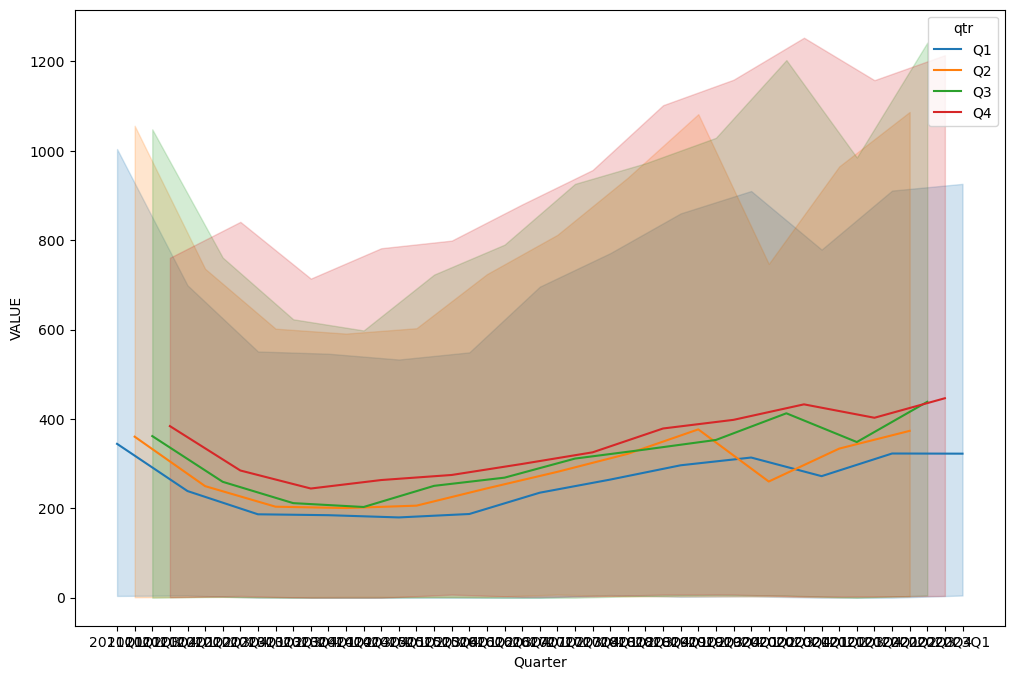

In [65]:
sns.lineplot(data=rural_df, x='Quarter', y='VALUE', hue='qtr')
plt.show()

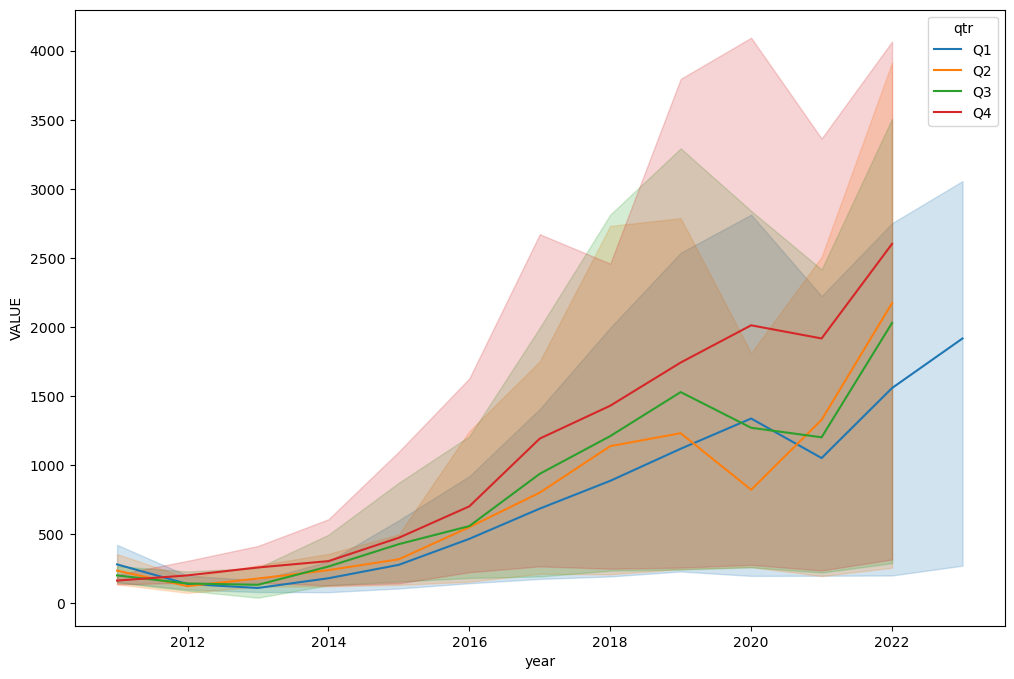

In [66]:
sns.lineplot(data=urban_df, x='year', y='VALUE', hue='qtr')
plt.show()

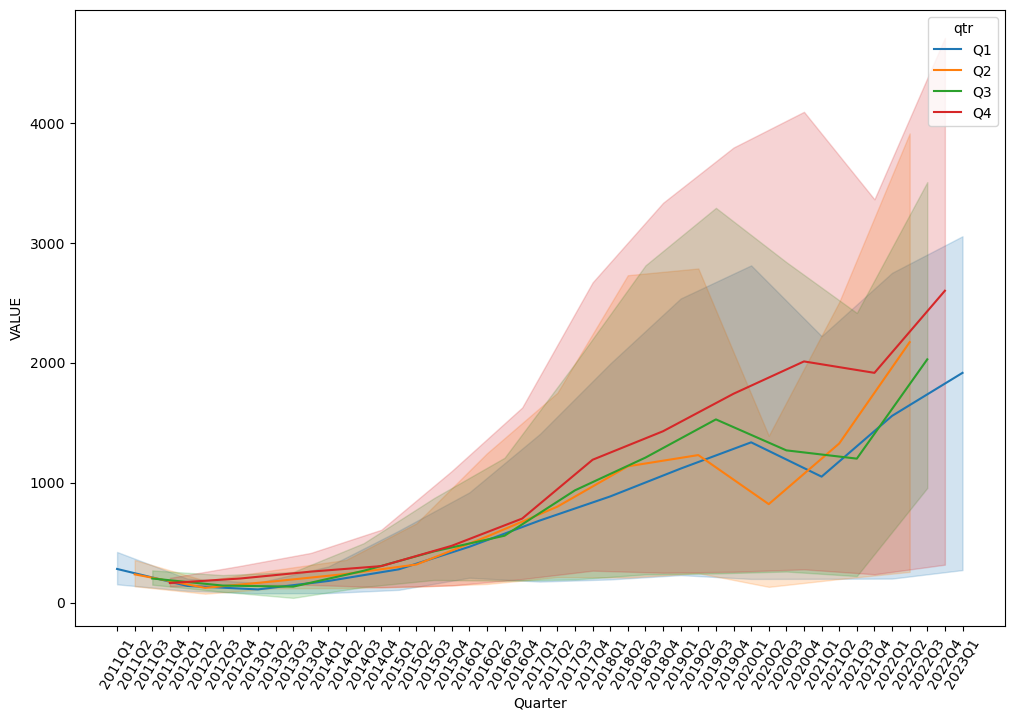

In [67]:
sns.lineplot(data=urban_df, x='Quarter', y='VALUE', hue='qtr')
plt.xticks(rotation=60)

plt.show()

## IE DF no.3

In [68]:
dict_county_mapping = {'Dún Laoghaire Rathdown':"Dublin", 'Fingal':"Dublin", 'South Dublin':"Dublin"}

In [69]:
def get_county_province_mapping():
    # Create a dictionary to map county to province using a table from Wikipedia.
    # Reading the html populates the list 'tables' with all tables parsed from the HTML.
    # A manual review of tables is necessary to ensure that the table is correct.
    # TODO - add error checking or write to file and read the csv each time this run/
    tables = pd.read_html("https://en.wikipedia.org/wiki/Counties_of_Ireland")
    ie_county_details = tables[3]
    ie_county_details.head()
    # ie_county_details.to_csv('./datasets/county_province_names.csv')
    # Select relevant columns.
    df_county_province_mapping = ie_county_details[['County', 'Province']]

    # Remove trailing characters from the County names.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("\[[A-Za-z]\]", "", regex=True)

    # Adjust Londonderry to Derry to match other datasources.
    df_county_province_mapping.loc[:,'County'] = df_county_province_mapping['County'].str.replace("Londonderry", "Derry")

    # Change all column headers to lower case.
    df_county_province_mapping.columns = [col.lower() for col in df_county_province_mapping.columns]
    
    return df_county_province_mapping

In [70]:
def map_county_and_province(df, mapping_df):
    df = pd.merge(left=df, right=mapping_df, on='county', how='left')
    return df

In [71]:
def rollup_county_values(df):
        col_names = [col for col in df.columns if col != 'VALUE']
        df = df.groupby(col_names)['VALUE'].sum().reset_index()
        return df

In [72]:
def county_mapping(df, mapping_dict):
    """
    Insert docstring
    
    """
    df['CC_name'] = df['Local Authority'].str.split(' C', n=1).str[0]
    df['county'] = df['CC_name'].str.strip().replace(mapping_dict)
    df = df.drop(['CC_name', 'Local Authority'], axis=1)
    county_mapping_df = get_county_province_mapping()
    df = rollup_county_values(df)
    df = map_county_and_province(df, county_mapping_df)
    return df

In [73]:
df_ie_ndq5 = deepcopy(df_ie_ndq5_orig)

In [74]:
df_ie_ndq5.head()

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168


In [75]:
df_ie_ndq5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC        1568 non-null   object
 1   STATISTIC Label  1568 non-null   object
 2   TLIST(Q1)        1568 non-null   int64 
 3   Quarter          1568 non-null   object
 4   C03789V04537     1568 non-null   object
 5   Local Authority  1568 non-null   object
 6   UNIT             1568 non-null   object
 7   VALUE            1568 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 98.1+ KB


In [76]:
# For each value in C03789V04537, theres is one value for Local Authority, we can drop C03789V04537
df_ie_ndq5.groupby(['Local Authority'])['C03789V04537'].nunique()

Local Authority
Carlow County Council                    1
Cavan County Council                     1
Clare County Council                     1
Cork City Council                        1
Cork County Council                      1
Donegal County Council                   1
Dublin City Council                      1
Dún Laoghaire Rathdown County Council    1
Fingal County Council                    1
Galway City Council                      1
Galway County Council                    1
Ireland                                  1
Kerry County Council                     1
Kildare County Council                   1
Kilkenny County Council                  1
Laois County Council                     1
Leitrim County Council                   1
Limerick City & County Council           1
Longford County Council                  1
Louth County Council                     1
Mayo County Council                      1
Meath County Council                     1
Monaghan County Council               

In [77]:
df_ie_ndq5['auth_comp'] = df_ie_ndq5['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [78]:
# Sum of all 
df_ie_ndq5.pivot_table(index='UNIT',  columns='auth_comp', values='VALUE', aggfunc='sum', fill_value=0)

auth_comp,CC,Ireland
UNIT,,
Number,169997,169997


In [79]:
# Compare the totals for each dataframe at the highest agg level in the data
ndq1_total = df_ie_ndq1[df_ie_ndq1['Type of House']=='All house types']['VALUE'].sum()
ndq3_total = df_ie_ndq3[df_ie_ndq3['Type of House']=='All house types']['VALUE'].sum()
ndq5_total = df_ie_ndq5[df_ie_ndq5['Local Authority']=='Ireland']['VALUE'].sum()

In [80]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}")
print(ndq1_total - ndq5_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997
0


https://www.citizensinformation.ie/en/government_in_ireland/national_government/local_and_regional_government/functions_of_local_authorities.html  
Differentiating between City and County council will have no material as it is not possible to determine if a specific council  type controls rural or urban planning

In [81]:
df_ie_ndq5['CC_name'] = df_ie_ndq5['Local Authority'].str.split(' C', n=1).str[0]
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal


In [82]:
df_ie_ndq5['CC_name'].unique()

array(['Ireland', 'Cork', 'Clare', 'Cavan', 'Carlow', 'Dublin',
       'Dún Laoghaire Rathdown', 'Donegal', 'Fingal', 'Galway', 'Kildare',
       'Kilkenny', 'Kerry', 'Longford', 'Louth', 'Limerick', 'Leitrim',
       'Laois', 'Meath', 'Monaghan', 'Mayo', 'Offaly', 'Roscommon',
       'South Dublin', 'Sligo', 'Tipperary', 'Waterford', 'Westmeath',
       'Wicklow', 'Wexford'], dtype=object)

In [83]:
df_ie_ndq5['county'] = df_ie_ndq5['CC_name'].str.strip().replace(dict_county_mapping)

In [84]:
df_ie_ndq5.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C03789V04537,Local Authority,UNIT,VALUE,auth_comp,CC_name,county
0,NDQ05,New Dwelling Completion,20111,2011Q1,-,Ireland,Number,1875,Ireland,Ireland,Ireland
1,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,39,CC,Cork,Cork
2,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,52,CC,Clare,Clare
3,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,61,CC,Cavan,Cavan
4,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,168,CC,Cork,Cork
5,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17,CC,Carlow,Carlow
6,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,72,CC,Dublin,Dublin
7,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,30,CC,Dún Laoghaire Rathdown,Dublin
8,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,118,CC,Donegal,Donegal
9,NDQ05,New Dwelling Completion,20111,2011Q1,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,144,CC,Fingal,Dublin


In [85]:
df_ie_ndq5_cleaned = extract_year_and_qtr(df_ie_ndq5, 'Quarter')
df_ie_ndq5_cleaned = county_mapping(df_ie_ndq5_cleaned, dict_county_mapping)

In [86]:
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C03789V04537', 'UNIT', 'auth_comp']
df_ie_ndq5_cleaned = df_ie_ndq5_cleaned.drop(list_cols_to_drop, axis=1)

In [87]:
df_ie_ndq5_cleaned.head()

,STATISTIC Label,Quarter,county,year,qtr,VALUE,province
0,New Dwelling Completion,2011Q1,Ireland,2011,Q1,1875,NaN
1,New Dwelling Completion,2011Q1,Dublin,2011,Q1,72,Leinster
2,New Dwelling Completion,2011Q1,Cork,2011,Q1,39,Munster
3,New Dwelling Completion,2011Q1,Galway,2011,Q1,15,Connacht
4,New Dwelling Completion,2011Q1,Laois,2011,Q1,34,Leinster


In [88]:
ndq5_cleaned_total = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']['VALUE'].sum()

In [89]:
df_ie_ndq5_cleaned = df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['county']!='Ireland']

In [90]:
df_ie_ndq5_cleaned['prov_county'] = df_ie_ndq5_cleaned['province'].str.strip() +"-"+ df_ie_ndq5_cleaned['county'].str.strip()


In [91]:
# Test if pre-rollup values = post rollup values
assert(ndq5_total == ndq5_cleaned_total)

In [92]:
df_ie_ndq5_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 1 to 1567
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   STATISTIC Label  1519 non-null   object
 1   Quarter          1519 non-null   object
 2   county           1519 non-null   object
 3   year             1519 non-null   int64 
 4   qtr              1519 non-null   object
 5   VALUE            1519 non-null   int64 
 6   province         1519 non-null   object
 7   prov_county      1519 non-null   object
dtypes: int64(2), object(6)
memory usage: 106.8+ KB


In [93]:
df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['VALUE']==0]

,STATISTIC Label,Quarter,county,year,qtr,VALUE,province,prov_county


In [94]:
df_ie_ndq5_cleaned['VALUE'].min()

3

In [95]:
df_ie_ndq5_pivot = df_ie_ndq5_cleaned.pivot_table(index=['Quarter'], columns=['prov_county'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [96]:
df_ie_ndq5_pivot.head()

prov_county,Quarter,Connacht-Galway,Connacht-Leitrim,Connacht-Mayo,Connacht-Roscommon,Connacht-Sligo,Leinster-Carlow,Leinster-Dublin,Leinster-Kildare,Leinster-Kilkenny,...,Leinster-Wicklow,Munster-Clare,Munster-Cork,Munster-Kerry,Munster-Limerick,Munster-Tipperary,Munster-Waterford,Ulster-Cavan,Ulster-Donegal,Ulster-Monaghan
0,2011Q1,108,42,67,26,52,17,287,126,40,...,74,52,207,62,54,63,96,61,118,26
1,2011Q2,125,13,59,54,34,24,327,42,50,...,37,49,236,67,49,94,29,28,139,21
2,2011Q3,114,14,124,38,35,24,181,42,84,...,60,47,215,77,55,73,30,45,115,33
3,2011Q4,125,16,88,31,24,38,169,76,54,...,47,57,219,79,95,68,35,37,88,32
4,2012Q1,83,15,41,19,62,17,110,51,26,...,23,44,142,46,27,40,18,20,114,42


In [97]:
df_ie_ndq5_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Quarter             49 non-null     object
 1   Connacht-Galway     49 non-null     int64 
 2   Connacht-Leitrim    49 non-null     int64 
 3   Connacht-Mayo       49 non-null     int64 
 4   Connacht-Roscommon  49 non-null     int64 
 5   Connacht-Sligo      49 non-null     int64 
 6   Leinster-Carlow     49 non-null     int64 
 7   Leinster-Dublin     49 non-null     int64 
 8   Leinster-Kildare    49 non-null     int64 
 9   Leinster-Kilkenny   49 non-null     int64 
 10  Leinster-Laois      49 non-null     int64 
 11  Leinster-Longford   49 non-null     int64 
 12  Leinster-Louth      49 non-null     int64 
 13  Leinster-Meath      49 non-null     int64 
 14  Leinster-Offaly     49 non-null     int64 
 15  Leinster-Westmeath  49 non-null     int64 
 16  Leinster-Wexford    49 non-n

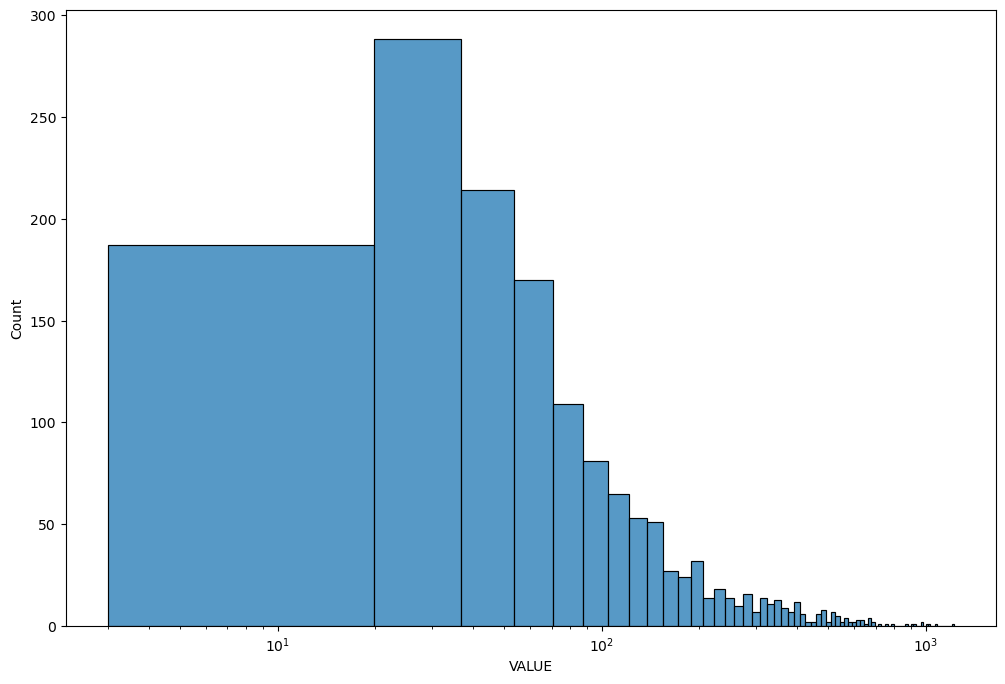

In [98]:
hp = sns.histplot(data=df_ie_ndq5_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

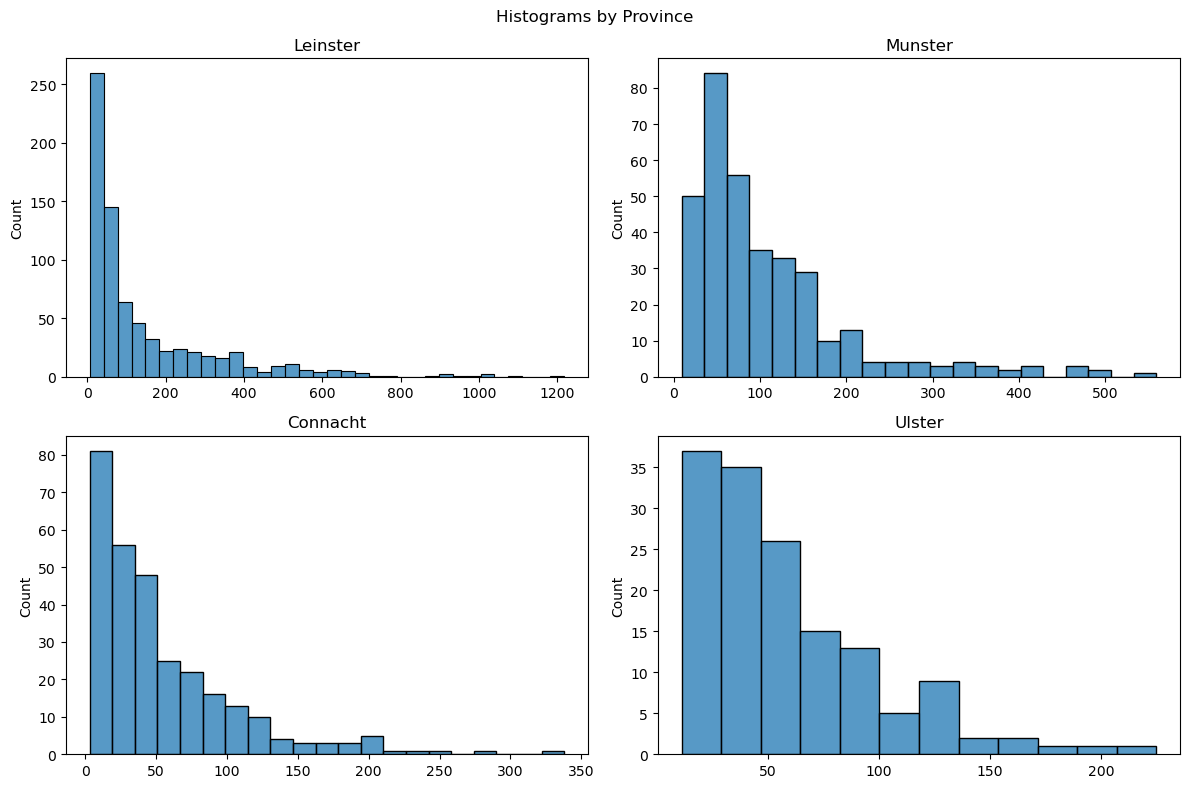

In [99]:
# Create figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Create histograms
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Leinster'], x="VALUE", kde=False, ax=axs[0, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Munster'], x="VALUE", kde=False, ax=axs[0, 1])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Connacht'], x="VALUE", kde=False, ax=axs[1, 0])
sns.histplot(data=df_ie_ndq5_cleaned[df_ie_ndq5_cleaned['province']=='Ulster'], x="VALUE", kde=False, ax=axs[1, 1])

# Set titles and axis labels
axs[0, 0].set_title("Leinster")
axs[0, 1].set_title("Munster")
axs[1, 0].set_title("Connacht")
axs[1, 1].set_title("Ulster")
fig.suptitle("Histograms by Province")
for ax in axs.flat:
    ax.set(xlabel=None, ylabel="Count")

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

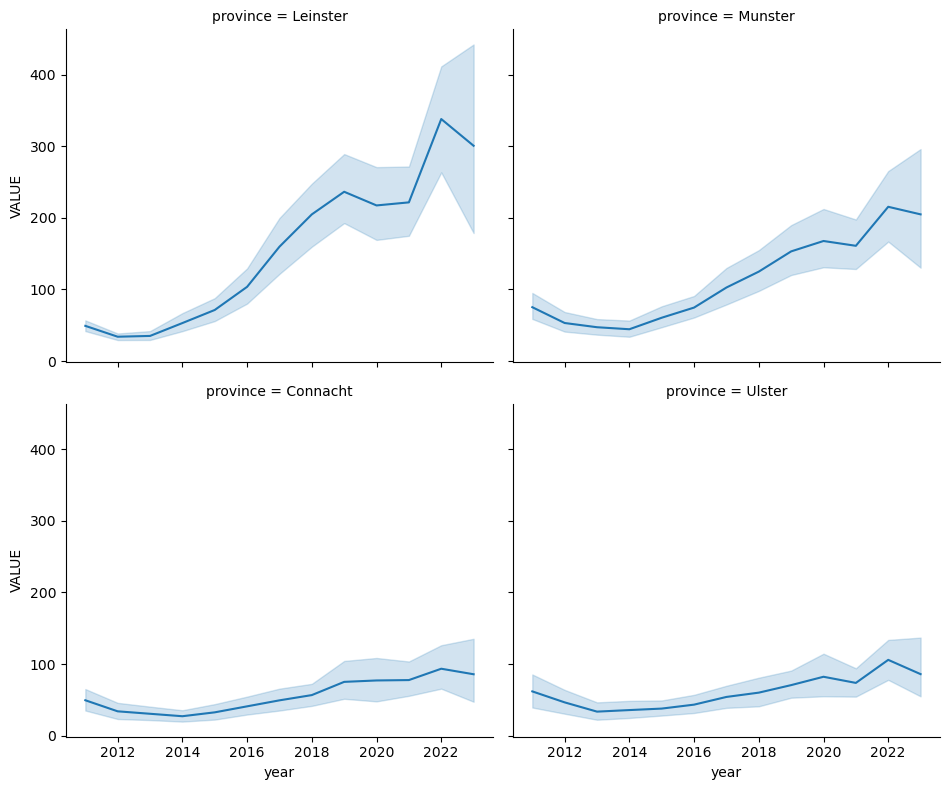

In [100]:
sns.relplot(data=df_ie_ndq5_cleaned, kind='line', x='year', y='VALUE', 
            col='province', col_wrap=2, height=4, aspect=1.2, legend=True)
plt.show()

## IE DF no.4

In [101]:
df_ie_ndq6 = deepcopy(df_ie_ndq6_orig)

In [102]:
df_ie_ndq6.head(10)

,STATISTIC,STATISTIC Label,TLIST(Q1),Quarter,C02342V02816,Type of House,C03789V04537,Local Authority,UNIT,VALUE
0,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1434-13a3-e055-000000000001,Cork City Council,Number,8
1,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a2-13a3-e055-000000000001,Clare County Council,Number,45
2,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149d-13a3-e055-000000000001,Cavan County Council,Number,21
3,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a3-13a3-e055-000000000001,Cork County Council,Number,145
4,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1492-13a3-e055-000000000001,Carlow County Council,Number,17
5,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-1433-13a3-e055-000000000001,Dublin City Council,Number,6
6,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-149f-13a3-e055-000000000001,Dún Laoghaire Rathdown County Council,Number,16
7,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a4-13a3-e055-000000000001,Donegal County Council,Number,82
8,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a0-13a3-e055-000000000001,Fingal County Council,Number,17
9,NDQ06,New Dwelling Completion,20111,2011Q1,06,Single house,2ae19629-14a5-13a3-e055-000000000001,Galway County Council,Number,92


In [103]:
df_ie_ndq6 = extract_year_and_qtr(df_ie_ndq6, 'Quarter')

In [104]:
# From previous cleaning we know that C02342V02816 & C03789V04537 map to type of house & local authority.
list_cols_to_drop = ['STATISTIC', 'TLIST(Q1)', 'C02342V02816', 'C03789V04537', 'UNIT']
df_ie_ndq6 = df_ie_ndq6.drop(list_cols_to_drop, axis=1)

In [105]:
df_ie_ndq6.head(10)

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr
0,New Dwelling Completion,2011Q1,Single house,Cork City Council,8,2011,Q1
1,New Dwelling Completion,2011Q1,Single house,Clare County Council,45,2011,Q1
2,New Dwelling Completion,2011Q1,Single house,Cavan County Council,21,2011,Q1
3,New Dwelling Completion,2011Q1,Single house,Cork County Council,145,2011,Q1
4,New Dwelling Completion,2011Q1,Single house,Carlow County Council,17,2011,Q1
5,New Dwelling Completion,2011Q1,Single house,Dublin City Council,6,2011,Q1
6,New Dwelling Completion,2011Q1,Single house,Dún Laoghaire Rathdown County Council,16,2011,Q1
7,New Dwelling Completion,2011Q1,Single house,Donegal County Council,82,2011,Q1
8,New Dwelling Completion,2011Q1,Single house,Fingal County Council,17,2011,Q1
9,New Dwelling Completion,2011Q1,Single house,Galway County Council,92,2011,Q1


In [106]:
df_ie_ndq6.describe(include='all')

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr
count,6272,6272,6272,6272,6272.000000,6272.000000,6272
unique,1,49,4,32,NaN,NaN,4
top,New Dwelling Completion,2011Q1,Single house,Cork City Council,NaN,NaN,Q1
freq,6272,128,1568,196,NaN,NaN,1664
mean,NaN,NaN,NaN,NaN,108.416454,2016.632653,NaN
std,NaN,NaN,NaN,NaN,430.696441,3.538377,NaN
min,NaN,NaN,NaN,NaN,0.000000,2011.000000,NaN
25%,NaN,NaN,NaN,NaN,6.000000,2014.000000,NaN
50%,NaN,NaN,NaN,NaN,24.000000,2017.000000,NaN
75%,NaN,NaN,NaN,NaN,64.000000,2020.000000,NaN


In [107]:
df_ie_ndq6['auth_comp'] = df_ie_ndq6['Local Authority'].apply(lambda x: 'CC' if x != "Ireland" else x)

In [108]:
df_ie_ndq6.head()

,STATISTIC Label,Quarter,Type of House,Local Authority,VALUE,year,qtr,auth_comp
0,New Dwelling Completion,2011Q1,Single house,Cork City Council,8,2011,Q1,CC
1,New Dwelling Completion,2011Q1,Single house,Clare County Council,45,2011,Q1,CC
2,New Dwelling Completion,2011Q1,Single house,Cavan County Council,21,2011,Q1,CC
3,New Dwelling Completion,2011Q1,Single house,Cork County Council,145,2011,Q1,CC
4,New Dwelling Completion,2011Q1,Single house,Carlow County Council,17,2011,Q1,CC


Duplication for fields Type of House & Local Authority.

In [109]:
ndq6_total = df_ie_ndq6[(df_ie_ndq6['auth_comp']=='CC') & (df_ie_ndq6['Type of House']=='All house types')]['VALUE'].sum()


In [110]:
print(f"NDQ1: {ndq1_total}, NDQ3: {ndq3_total}, NDQ5: {ndq5_total}, NDQ6: {ndq6_total}")
print(ndq1_total - ndq6_total)

NDQ1: 169997, NDQ3: 169985, NDQ5: 169997, NDQ6: 169997
0


In [111]:
df_ie_ndq6_cleaned = county_mapping(df_ie_ndq6, dict_county_mapping)

In [112]:
df_ie_ndq6_cleaned.head(10)

,STATISTIC Label,Quarter,Type of House,year,qtr,auth_comp,county,VALUE,province
0,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Carlow,17,Leinster
1,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Cavan,61,Ulster
2,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Clare,52,Munster
3,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Cork,207,Munster
4,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Donegal,118,Ulster
5,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Dublin,287,Leinster
6,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Galway,108,Connacht
7,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kerry,62,Munster
8,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kildare,126,Leinster
9,New Dwelling Completion,2011Q1,All house types,2011,Q1,CC,Kilkenny,40,Leinster


In [113]:
assert(df_ie_ndq6_cleaned['VALUE'].sum() == df_ie_ndq6_orig['VALUE'].sum())

In [114]:
df_ie_ndq6_cleaned['prov_county_house'] = df_ie_ndq6_cleaned['province'].str.strip() +"-"+ \
                                            df_ie_ndq6_cleaned['county'].str.strip() +"-"+ \
                                            df_ie_ndq6_cleaned['Type of House']

In [115]:
df_ie_ndq6_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5292 entries, 0 to 5291
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    5292 non-null   object
 1   Quarter            5292 non-null   object
 2   Type of House      5292 non-null   object
 3   year               5292 non-null   int64 
 4   qtr                5292 non-null   object
 5   auth_comp          5292 non-null   object
 6   county             5292 non-null   object
 7   VALUE              5292 non-null   int64 
 8   province           5096 non-null   object
 9   prov_county_house  5096 non-null   object
dtypes: int64(2), object(8)
memory usage: 454.8+ KB


# Remove the 'Ireland' county to avoid duplication

In [116]:
df_ie_ndq6_cleaned[(df_ie_ndq6_cleaned['county']!='Ireland')].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5096 entries, 0 to 5290
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    5096 non-null   object
 1   Quarter            5096 non-null   object
 2   Type of House      5096 non-null   object
 3   year               5096 non-null   int64 
 4   qtr                5096 non-null   object
 5   auth_comp          5096 non-null   object
 6   county             5096 non-null   object
 7   VALUE              5096 non-null   int64 
 8   province           5096 non-null   object
 9   prov_county_house  5096 non-null   object
dtypes: int64(2), object(8)
memory usage: 437.9+ KB


# Remove 'All house types' to avoid duplication

In [117]:
df_ie_ndq6_cleaned = df_ie_ndq6_cleaned[(df_ie_ndq6_cleaned['county']!='Ireland') & (df_ie_ndq6_cleaned['Type of House']!='All house types')]


In [118]:
df_ie_ndq6_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3822 entries, 27 to 5290
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    3822 non-null   object
 1   Quarter            3822 non-null   object
 2   Type of House      3822 non-null   object
 3   year               3822 non-null   int64 
 4   qtr                3822 non-null   object
 5   auth_comp          3822 non-null   object
 6   county             3822 non-null   object
 7   VALUE              3822 non-null   int64 
 8   province           3822 non-null   object
 9   prov_county_house  3822 non-null   object
dtypes: int64(2), object(8)
memory usage: 328.5+ KB


In [119]:
df_ie_ndq6_pivot = df_ie_ndq6_cleaned.pivot_table(index=['Quarter'], columns=['prov_county_house'], values='VALUE', aggfunc='sum', fill_value=0).reset_index()


In [120]:
df_ie_ndq6_pivot

prov_county_house,Quarter,Connacht-Galway-Apartment,Connacht-Galway-Scheme house,Connacht-Galway-Single house,Connacht-Leitrim-Apartment,Connacht-Leitrim-Scheme house,Connacht-Leitrim-Single house,Connacht-Mayo-Apartment,Connacht-Mayo-Scheme house,Connacht-Mayo-Single house,...,Munster-Waterford-Single house,Ulster-Cavan-Apartment,Ulster-Cavan-Scheme house,Ulster-Cavan-Single house,Ulster-Donegal-Apartment,Ulster-Donegal-Scheme house,Ulster-Donegal-Single house,Ulster-Monaghan-Apartment,Ulster-Monaghan-Scheme house,Ulster-Monaghan-Single house
0,2011Q1,7,6,95,22,0,20,0,3,64,...,35,1,39,21,12,24,82,0,3,23
1,2011Q2,1,13,111,0,0,13,4,9,46,...,26,0,1,27,1,32,106,1,0,20
2,2011Q3,8,6,100,0,0,14,10,39,75,...,23,0,2,43,1,15,99,2,2,29
3,2011Q4,2,10,113,0,1,15,0,14,74,...,32,0,14,23,6,4,78,1,4,27
4,2012Q1,9,4,70,0,0,15,0,6,35,...,11,0,1,19,10,35,69,1,21,20
5,2012Q2,3,2,73,0,0,7,0,6,50,...,14,1,0,22,6,3,65,0,0,18
6,2012Q3,5,1,70,1,3,9,1,0,53,...,17,0,0,23,0,9,83,0,1,26
7,2012Q4,7,2,87,0,0,9,0,0,45,...,30,1,0,32,1,1,76,0,0,15
8,2013Q1,0,4,74,0,0,10,4,0,34,...,20,0,0,15,4,9,41,0,3,13
9,2013Q2,28,0,60,4,0,8,2,1,42,...,15,0,1,16,2,2,56,0,2,13


In [121]:
df_ie_ndq6_pivot.head()

prov_county_house,Quarter,Connacht-Galway-Apartment,Connacht-Galway-Scheme house,Connacht-Galway-Single house,Connacht-Leitrim-Apartment,Connacht-Leitrim-Scheme house,Connacht-Leitrim-Single house,Connacht-Mayo-Apartment,Connacht-Mayo-Scheme house,Connacht-Mayo-Single house,...,Munster-Waterford-Single house,Ulster-Cavan-Apartment,Ulster-Cavan-Scheme house,Ulster-Cavan-Single house,Ulster-Donegal-Apartment,Ulster-Donegal-Scheme house,Ulster-Donegal-Single house,Ulster-Monaghan-Apartment,Ulster-Monaghan-Scheme house,Ulster-Monaghan-Single house
0,2011Q1,7,6,95,22,0,20,0,3,64,...,35,1,39,21,12,24,82,0,3,23
1,2011Q2,1,13,111,0,0,13,4,9,46,...,26,0,1,27,1,32,106,1,0,20
2,2011Q3,8,6,100,0,0,14,10,39,75,...,23,0,2,43,1,15,99,2,2,29
3,2011Q4,2,10,113,0,1,15,0,14,74,...,32,0,14,23,6,4,78,1,4,27
4,2012Q1,9,4,70,0,0,15,0,6,35,...,11,0,1,19,10,35,69,1,21,20


In [122]:
df_ie_ndq6_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Quarter                          49 non-null     object
 1   Connacht-Galway-Apartment        49 non-null     int64 
 2   Connacht-Galway-Scheme house     49 non-null     int64 
 3   Connacht-Galway-Single house     49 non-null     int64 
 4   Connacht-Leitrim-Apartment       49 non-null     int64 
 5   Connacht-Leitrim-Scheme house    49 non-null     int64 
 6   Connacht-Leitrim-Single house    49 non-null     int64 
 7   Connacht-Mayo-Apartment          49 non-null     int64 
 8   Connacht-Mayo-Scheme house       49 non-null     int64 
 9   Connacht-Mayo-Single house       49 non-null     int64 
 10  Connacht-Roscommon-Apartment     49 non-null     int64 
 11  Connacht-Roscommon-Scheme house  49 non-null     int64 
 12  Connacht-Roscommon-Single house  49 no

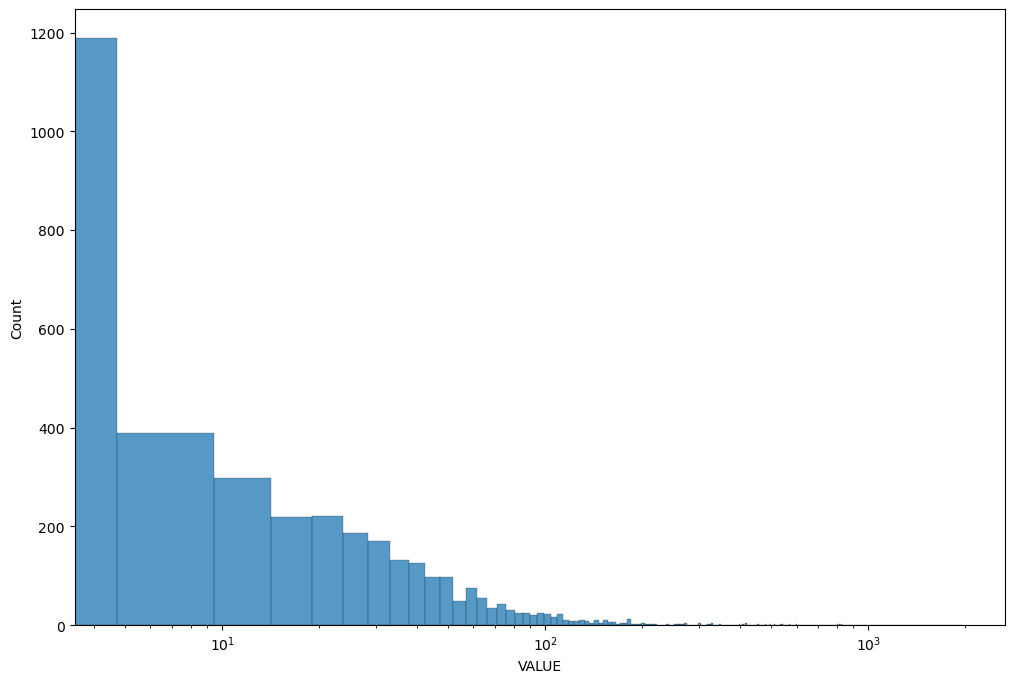

In [123]:
hp = sns.histplot(data=df_ie_ndq6_cleaned, x='VALUE')
hp.set_xscale('log')
plt.show()

In [124]:
df_ie_ndq6_cleaned['VALUE'].min()

0

In [125]:
df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]

,STATISTIC Label,Quarter,Type of House,year,qtr,auth_comp,county,VALUE,province,prov_county_house
27,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Carlow,0,Leinster,Leinster-Carlow-Apartment
37,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Laois,0,Leinster,Leinster-Laois-Apartment
40,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Longford,0,Leinster,Leinster-Longford-Apartment
41,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Louth,0,Leinster,Leinster-Louth-Apartment
42,New Dwelling Completion,2011Q1,Apartment,2011,Q1,CC,Mayo,0,Connacht,Connacht-Mayo-Apartment
...,...,...,...,...,...,...,...,...,...,...
5012,New Dwelling Completion,2022Q3,Apartment,2022,Q3,CC,Monaghan,0,Ulster,Ulster-Monaghan-Apartment
5105,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Clare,0,Munster,Munster-Clare-Apartment
5114,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Leitrim,0,Connacht,Connacht-Leitrim-Apartment
5123,New Dwelling Completion,2022Q4,Apartment,2022,Q4,CC,Sligo,0,Connacht,Connacht-Sligo-Apartment


<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 27 to 5211
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   STATISTIC Label    547 non-null    object
 1   Quarter            547 non-null    object
 2   Type of House      547 non-null    object
 3   year               547 non-null    int64 
 4   qtr                547 non-null    object
 5   auth_comp          547 non-null    object
 6   county             547 non-null    object
 7   VALUE              547 non-null    int64 
 8   province           547 non-null    object
 9   prov_county_house  547 non-null    object
dtypes: int64(2), object(8)
memory usage: 47.0+ KB
None


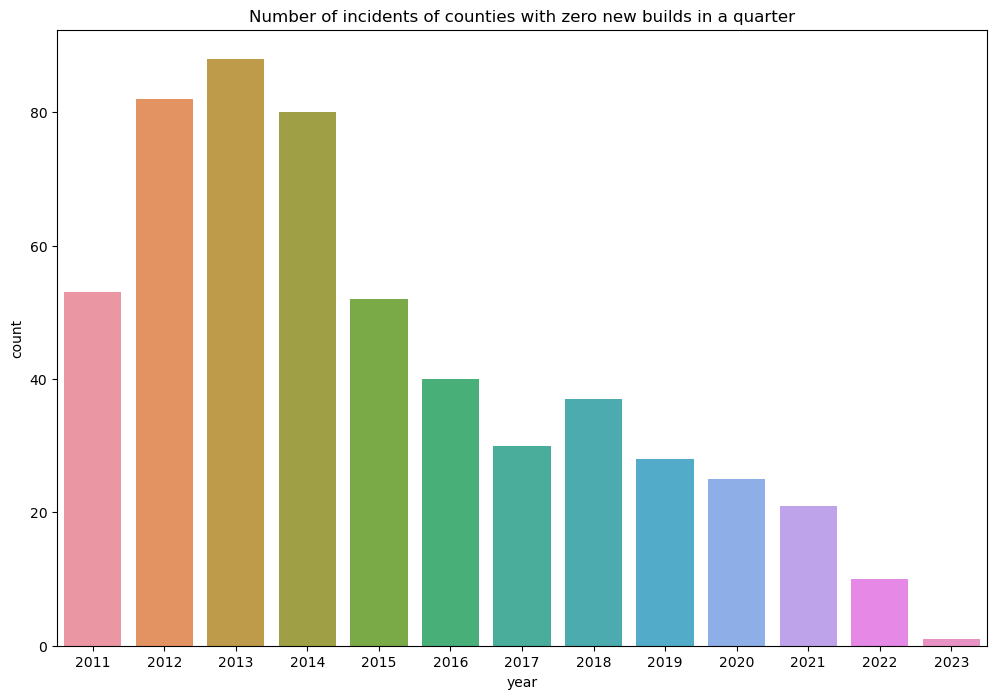

In [126]:
zero_new = df_ie_ndq6_cleaned[df_ie_ndq6_cleaned['VALUE']==0]
print(zero_new.info())
z_plot = sns.countplot(data=zero_new, x='year')
z_plot.set_title('Number of incidents of counties with zero new builds in a quarter')
plt.show()

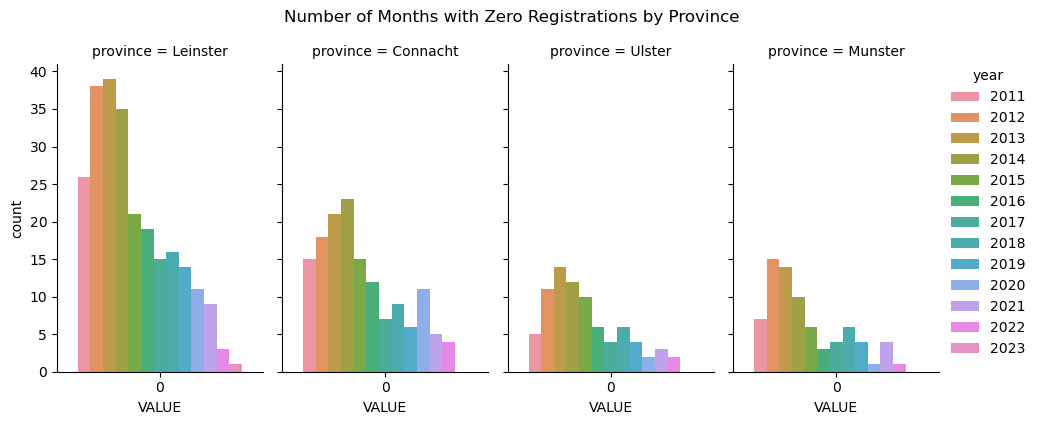

In [127]:
cp = sns.catplot(
    data=zero_new, x="VALUE", col="province", hue='year',
    kind="count", height=4, aspect=0.6
)
cp.fig.suptitle('Number of Months with Zero Registrations by Province', y=1.05)
plt.show()

## Joining together the IE dataset

In [128]:
df_ie_final = pd.merge(left=df_ie_ndq1_pivot, 
                       right=df_ie_ndq3_pivot, 
                       on='Quarter', how='left')

In [129]:
df_ie_final.head()

,Quarter,year,qtr,All house types,Apartment,Scheme house,Single house,Apartment-Rural areas,Apartment-Urban areas,Scheme house-Rural areas,Scheme house-Urban areas,Single house-Rural areas,Single house-Urban areas
0,2011Q1,2011,Q1,1875,272,447,1156,4,267,25,422,1004,152
1,2011Q2,2011,Q2,1791,217,380,1194,1,215,24,355,1056,136
2,2011Q3,2011,Q3,1687,185,305,1197,0,185,37,268,1048,149
3,2011Q4,2011,Q4,1641,148,226,1267,1,147,20,206,1131,136
4,2012Q1,2012,Q1,1131,123,211,797,5,118,12,199,699,98


In [130]:
df_ie_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   year                      49 non-null     int64 
 2   qtr                       49 non-null     object
 3   All house types           49 non-null     int64 
 4   Apartment                 49 non-null     int64 
 5   Scheme house              49 non-null     int64 
 6   Single house              49 non-null     int64 
 7   Apartment-Rural areas     49 non-null     int64 
 8   Apartment-Urban areas     49 non-null     int64 
 9   Scheme house-Rural areas  49 non-null     int64 
 10  Scheme house-Urban areas  49 non-null     int64 
 11  Single house-Rural areas  49 non-null     int64 
 12  Single house-Urban areas  49 non-null     int64 
dtypes: int64(11), object(2)
memory usage: 5.4+ KB


In [131]:
df_ie_final = pd.merge(left=df_ie_final, 
                       right=df_ie_ndq5_pivot, 
                       on='Quarter', how='left')

In [132]:
df_ie_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Quarter                   49 non-null     object
 1   year                      49 non-null     int64 
 2   qtr                       49 non-null     object
 3   All house types           49 non-null     int64 
 4   Apartment                 49 non-null     int64 
 5   Scheme house              49 non-null     int64 
 6   Single house              49 non-null     int64 
 7   Apartment-Rural areas     49 non-null     int64 
 8   Apartment-Urban areas     49 non-null     int64 
 9   Scheme house-Rural areas  49 non-null     int64 
 10  Scheme house-Urban areas  49 non-null     int64 
 11  Single house-Rural areas  49 non-null     int64 
 12  Single house-Urban areas  49 non-null     int64 
 13  Connacht-Galway           49 non-null     int64 
 14  Connacht-Leitrim          49

In [133]:
df_ie_final = pd.merge(left=df_ie_final, 
                       right=df_ie_ndq6_pivot, 
                       on='Quarter', how='left')

In [134]:
df_ie_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 117 columns):
 #    Column                           Dtype 
---   ------                           ----- 
 0    Quarter                          object
 1    year                             int64 
 2    qtr                              object
 3    All house types                  int64 
 4    Apartment                        int64 
 5    Scheme house                     int64 
 6    Single house                     int64 
 7    Apartment-Rural areas            int64 
 8    Apartment-Urban areas            int64 
 9    Scheme house-Rural areas         int64 
 10   Scheme house-Urban areas         int64 
 11   Single house-Rural areas         int64 
 12   Single house-Urban areas         int64 
 13   Connacht-Galway                  int64 
 14   Connacht-Leitrim                 int64 
 15   Connacht-Mayo                    int64 
 16   Connacht-Roscommon               int64 
 17   Connacht-Sligo  

# DF UK

# Check which sheet to read from the spreadsheet.

In [135]:
df_uk_con_output = deepcopy(df_uk_con_output_orig)

In [136]:
df_uk_con_output_orig.head(50)

,Contents,Unnamed: 1
0,Metadata,Information on the UK house building dataset
1,Quarterly (from Jan-Mar 1978),NaN
2,Table 1a - United Kingdom,House building: permanent dwellings started an...
3,Table 1b - England,House building: permanent dwellings started an...
4,Table 1c - Wales,House building: permanent dwellings started an...
5,Table 1d - Scotland,House building: permanent dwellings started an...
6,Table 1e - Northern Ireland,House building: permanent dwellings started an...
7,Table 1f - Great Britain,House building: permanent dwellings started an...
8,Financial year (from 1969-70),NaN
9,Table 2a - United Kingdom,House building: permanent dwellings started an...


In [137]:
df_uk_con_england = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1b', header=5)
df_uk_con_wales = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1c', header=5)
df_uk_con_scotland = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1d', header=5)
df_uk_con_ni = pd.read_excel('./datasets/uk/outputukhousebuilding.xlsx', sheet_name='1e', header=5)

In [138]:
df_uk_con_england.head(10)

,Revised,Period,Started - All Dwellings,Started - Private Enterprise,Started - Housing Associations,Started - Local Authorities,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities
0,NaN,Jan - Mar 1978,45700,25880,4460,15360,57360,30230,4840,22290
1,NaN,Apr - Jun 1978,69520,39760,4810,24950,61450,32930,4980,23540
2,NaN,Jul - Sep 1978,59340,34490,4590,20270,59160,30620,5260,23280
3,NaN,Oct - Dec 1978,52130,33450,4100,14580,63340,33660,5480,24200
4,NaN,Jan - Mar 1979,31960,19060,3220,9680,43380,24810,4160,14410
5,NaN,Apr - Jun 1979,54080,33300,4130,16650,48790,27840,3450,17490
6,NaN,Jul - Sep 1979,52850,34260,3200,15380,47160,26130,3490,17540
7,NaN,Oct - Dec 1979,51690,34510,3690,13480,70130,39600,5180,25350
8,NaN,Jan - Mar 1980,33160,20470,3140,9560,49600,27730,4550,17320
9,NaN,Apr - Jun 1980,38710,25210,3490,10010,49400,26250,4950,18200


In [139]:
df_uk_con_england = df_uk_con_england.drop(['Revised'], axis=1)

In [140]:
df_uk_con_england['year'] = df_uk_con_england['Period'].str[-4:]
df_uk_con_england['time_period'] = df_uk_con_england['Period'].str[:-4]

In [141]:
dict_quarter_mapping = {"Jan - Mar": "Q1", "Apr - Jun": "Q2", "Jul - Sep": "Q3", "Oct - Dec": "Q4"}

In [142]:
df_uk_con_england['quarter'] = df_uk_con_england['time_period'].str.strip().replace(dict_quarter_mapping)
df_uk_con_england['yr_qtr'] = df_uk_con_england['year'] + df_uk_con_england['quarter']

In [143]:
list_cols_to_drop = [col for col in df_uk_con_england.columns if "Started" in str(col)]

In [144]:
list_cols_to_drop.extend(['Period', 'time_period'])

In [145]:
df_uk_con_england = df_uk_con_england.drop(list_cols_to_drop, axis=1)

In [146]:
df_uk_con_england.head()

,Completed - All Dwellings,Completed - Private Enterprise,Completed - Housing Associations,Completed - Local Authorities,year,quarter,yr_qtr
0,57360,30230,4840,22290,1978,Q1,1978Q1
1,61450,32930,4980,23540,1978,Q2,1978Q2
2,59160,30620,5260,23280,1978,Q3,1978Q3
3,63340,33660,5480,24200,1978,Q4,1978Q4
4,43380,24810,4160,14410,1979,Q1,1979Q1


In [147]:
df_uk_con_england.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Completed - All Dwellings         179 non-null    int64 
 1   Completed - Private Enterprise    179 non-null    int64 
 2   Completed - Housing Associations  179 non-null    int64 
 3   Completed - Local Authorities     179 non-null    object
 4   year                              179 non-null    object
 5   quarter                           179 non-null    object
 6   yr_qtr                            179 non-null    object
dtypes: int64(3), object(4)
memory usage: 9.9+ KB


In [148]:
def prepare_uk_df(df, qtr_dict):
    """
    
    ADD DOCSTRING
    
    """
    df['year'] = df['Period'].str[-4:]
    df['time_period'] = df['Period'].str[:-4]
    df['quarter'] = df['time_period'].str.strip().replace(qtr_dict)
    df['yr_qtr'] = df['year'] + df['quarter']
    list_cols_to_drop = [col for col in df.columns if "Started" in str(col)]
    list_cols_to_drop.extend(['Revised', 'Period', 'time_period'])
    df = df.drop(list_cols_to_drop, axis=1)
    return df

In [149]:
df_uk_con_wales = prepare_uk_df(df_uk_con_wales, dict_quarter_mapping)
df_uk_con_scotland = prepare_uk_df(df_uk_con_scotland, dict_quarter_mapping)
df_uk_con_ni = prepare_uk_df(df_uk_con_ni, dict_quarter_mapping)

# DF Population

In [150]:
# https://data.worldbank.org/indicator/SP.POP.TOTL
# Load the XML file
pop_files = glob.glob('./datasets/pop/*.xml')

In [151]:
try:
    with open(pop_files[0], 'r') as file:

        # Print the first 5 lines of the file
        for i in range(20):
            print(file.readline())
except exception as e:
    print('Error: ' + e)
finally:
        file.close()

ï»¿<?xml version="1.0" encoding="utf-8"?>

<Root xmlns:wb="http://www.worldbank.org">

  <data>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1960</field>

      <field name="Value">54608</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1961</field>

      <field name="Value">55811</field>

    </record>

    <record>

      <field name="Country or Area" key="ABW">Aruba</field>

      <field name="Item" key="SP.POP.TOTL">Population, total</field>

      <field name="Year">1962</field>

      <field name="Value">56682</field>



In [152]:
tree = ET.parse(pop_files[0])

# Get the root element of the XML file
root = tree.getroot()

# List to store the parsed xml data before converting to a dataframe
data_list = []

# Loop through the records and append each row of data to the list as a dictionary
# Where the
for record in root.findall('data/record'):
    data_dict = {}
    for field in record.findall('field'):
#         if field.get('name') == 'Item':
#             continue
        name = field.get('name')
        value = field.text
        data_dict[name] = value
    data_list.append(data_dict)

In [153]:
# Create a DataFrame from the list
df_global_population = pd.DataFrame(data_list)

In [154]:
# Print the DataFrame
print(df_global_population['Item'].unique())

['Population, total']


In [155]:
df_global_population.head()

,Country or Area,Item,Year,Value
0,Aruba,"Population, total",1960,54608
1,Aruba,"Population, total",1961,55811
2,Aruba,"Population, total",1962,56682
3,Aruba,"Population, total",1963,57475
4,Aruba,"Population, total",1964,58178


In [156]:
df_global_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16492 entries, 0 to 16491
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country or Area  16492 non-null  object
 1   Item             16492 non-null  object
 2   Year             16492 non-null  object
 3   Value            16400 non-null  object
dtypes: object(4)
memory usage: 515.5+ KB


In [157]:
list_uki_countries = ['Ireland']
df_global_population[df_global_population['Country or Area'].isin(list_uki_countries)]

,Country or Area,Item,Year,Value
6882,Ireland,"Population, total",1960,2828600
6883,Ireland,"Population, total",1961,2824400
6884,Ireland,"Population, total",1962,2836050
6885,Ireland,"Population, total",1963,2852650
6886,Ireland,"Population, total",1964,2866550
...,...,...,...,...
6939,Ireland,"Population, total",2017,4807388
6940,Ireland,"Population, total",2018,4867316
6941,Ireland,"Population, total",2019,4934340
6942,Ireland,"Population, total",2020,4985382


In [158]:
df_ie_pop = df_global_population[df_global_population['Country or Area'].isin(list_uki_countries)]
df_ie_pop_year = df_ie_pop.drop(['Country or Area', 'Item'], axis=1)

In [159]:
df_ie_pop['year_qtr'] = df_ie_pop['Year'] + "Q1"
df_ie_pop = df_ie_pop.drop(['Country or Area', 'Item', 'Year'], axis=1)
df_ie_pop.columns=['ie_pop', 'year_qtr']

In [160]:
df_ie_pop.head()

,ie_pop,year_qtr
6882,2828600,1960Q1
6883,2824400,1961Q1
6884,2836050,1962Q1
6885,2852650,1963Q1
6886,2866550,1964Q1


In [161]:
df_ie_pop_year.head()

,Year,Value
6882,1960,2828600
6883,1961,2824400
6884,1962,2836050
6885,1963,2852650
6886,1964,2866550


# DF pop 2

# NOTE
These values were estimated in June (Q2) in each reference year.  
When imputing the iternal quarter values, the values should be labeled as Q3

In [162]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatestimeseriesdataset
df_uk_pop = pd.read_excel('./datasets/pop/pop.xlsx', sheet_name='data', header=1)

C:\Users\emers\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [163]:
df_uk_pop.head()

,CDID,SCPOP,GBPOP,ENPOP,UKPOP,EWPOP,NIPOP,WAPOP
0,PreUnit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Release Date,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022,21-12-2022
3,Next release,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023,Summer 2023
4,Important Notes,NaN,NaN,NaN,[Mid-year population estimates relate to the u...,NaN,NaN,NaN


In [164]:
list_pop_header_rows = ['PreUnit', 'Unit', 'Release Date', 'Next release', 'Important Notes']

In [165]:
df_uk_pop = df_uk_pop[~df_uk_pop['CDID'].isin(list_pop_header_rows)]

In [166]:
df_uk_pop.head()

,CDID,SCPOP,GBPOP,ENPOP,UKPOP,EWPOP,NIPOP,WAPOP
5,1971,5235600,54387600,46411700,55928000,49152000,1540400,2740300
6,1972,5230600,54557700,46571900,56096700,49327100,1539000,2755200
7,1973,5233900,54692900,46686200,56222900,49459000,1530000,2772800
8,1974,5240800,54708700,46682700,56235600,49467900,1526900,2785200
9,1975,5232400,54702200,46674400,56225700,49469800,1523500,2795400


In [167]:
list_pop_cols_to_keep = ['CDID', 'SCPOP', 'ENPOP', 'NIPOP', 'WAPOP']
df_uk_pop = df_uk_pop[list_pop_cols_to_keep]

In [168]:
df_uk_pop.head()

,CDID,SCPOP,ENPOP,NIPOP,WAPOP
5,1971,5235600,46411700,1540400,2740300
6,1972,5230600,46571900,1539000,2755200
7,1973,5233900,46686200,1530000,2772800
8,1974,5240800,46682700,1526900,2785200
9,1975,5232400,46674400,1523500,2795400


In [169]:
df_uk_pop.columns = ['year', 'scotland_pop', 'england_pop', 'ni_pop', 'wales_pop']

In [170]:
df_uk_pop.head()

,year,scotland_pop,england_pop,ni_pop,wales_pop
5,1971,5235600,46411700,1540400,2740300
6,1972,5230600,46571900,1539000,2755200
7,1973,5233900,46686200,1530000,2772800
8,1974,5240800,46682700,1526900,2785200
9,1975,5232400,46674400,1523500,2795400


In [171]:
df_uk_pop_year = deepcopy(df_uk_pop)

In [172]:
df_uk_pop['year_qtr'] = df_uk_pop['year'] + "Q2"
df_uk_pop_joining = df_uk_pop.drop(['year'], axis=1)

In [173]:
df_uk_pop.head()

,year,scotland_pop,england_pop,ni_pop,wales_pop,year_qtr
5,1971,5235600,46411700,1540400,2740300,1971Q2
6,1972,5230600,46571900,1539000,2755200,1972Q2
7,1973,5233900,46686200,1530000,2772800,1973Q2
8,1974,5240800,46682700,1526900,2785200,1974Q2
9,1975,5232400,46674400,1523500,2795400,1975Q2


In [174]:
years = np.repeat(df_uk_pop['year'].values, 4)

In [175]:
qtrs = ['Q1', 'Q2', 'Q3', 'Q4'] * len(df_uk_pop['year'].values)

In [176]:
assert(len(qtrs) == len(years))

# Join together population stats
Since UK has the lower number of years, we will use that as the basis for population comparison.

In [177]:
df_base_year_qtr = pd.DataFrame({'year':years, 'qtr':qtrs})
df_base_year_qtr['year_qtr'] = df_base_year_qtr['year'] + df_base_year_qtr['qtr']

In [178]:
df_base_year_qtr.head()

,year,qtr,year_qtr
0,1971,Q1,1971Q1
1,1971,Q2,1971Q2
2,1971,Q3,1971Q3
3,1971,Q4,1971Q4
4,1972,Q1,1972Q1


In [179]:
df_pop_all = pd.merge(left=df_base_year_qtr, right=df_uk_pop_joining, on='year_qtr', how='left')
df_pop_all = pd.merge(left=df_pop_all, right=df_ie_pop, on='year_qtr', how='left')

In [180]:
df_pop_all.head()

,year,qtr,year_qtr,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,1971,Q1,1971Q1,NaN,NaN,NaN,NaN,2992050
1,1971,Q2,1971Q2,5235600,46411700,1540400,2740300,NaN
2,1971,Q3,1971Q3,NaN,NaN,NaN,NaN,NaN
3,1971,Q4,1971Q4,NaN,NaN,NaN,NaN,NaN
4,1972,Q1,1972Q1,NaN,NaN,NaN,NaN,3036850


In [181]:
df_pop_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          204 non-null    object
 1   qtr           204 non-null    object
 2   year_qtr      204 non-null    object
 3   scotland_pop  51 non-null     object
 4   england_pop   51 non-null     object
 5   ni_pop        51 non-null     object
 6   wales_pop     51 non-null     object
 7   ie_pop        51 non-null     object
dtypes: object(8)
memory usage: 14.3+ KB


In [182]:
county_cols = [col_name for col_name in df_pop_all.columns if 'pop' in col_name]

In [183]:
df_pop_all[county_cols] = df_pop_all[county_cols].apply(pd.to_numeric)

In [184]:
df_pop_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          204 non-null    object 
 1   qtr           204 non-null    object 
 2   year_qtr      204 non-null    object 
 3   scotland_pop  51 non-null     float64
 4   england_pop   51 non-null     float64
 5   ni_pop        51 non-null     float64
 6   wales_pop     51 non-null     float64
 7   ie_pop        51 non-null     float64
dtypes: float64(5), object(3)
memory usage: 14.3+ KB


In [185]:
df_pop_interpolated = df_pop_all.interpolate(method ='linear', limit_direction ='backward')
df_pop_interpolated = df_pop_interpolated.interpolate(method ='linear', limit_direction ='forward')

In [186]:
df_pop_filled = df_pop_all.fillna(method='ffill')
df_pop_filled = df_pop_filled.fillna(method='bfill')

In [187]:
df_pop_all.head()

,year,qtr,year_qtr,scotland_pop,england_pop,ni_pop,wales_pop,ie_pop
0,1971,Q1,1971Q1,NaN,NaN,NaN,NaN,2992050.0
1,1971,Q2,1971Q2,5235600.0,46411700.0,1540400.0,2740300.0,NaN
2,1971,Q3,1971Q3,NaN,NaN,NaN,NaN,NaN
3,1971,Q4,1971Q4,NaN,NaN,NaN,NaN,NaN
4,1972,Q1,1972Q1,NaN,NaN,NaN,NaN,3036850.0


In [188]:
df_pop_all_long = df_pop_all.melt(id_vars=['year','qtr','year_qtr'])

In [189]:
df_pop_interpolated_long = df_pop_interpolated.melt(id_vars=['year','qtr','year_qtr'])

In [190]:
df_pop_filled_long = df_pop_filled.melt(id_vars=['year','qtr','year_qtr'])

In [191]:
df_pop_interpolated_long.head()

,year,qtr,year_qtr,variable,value
0,1971,Q1,1971Q1,scotland_pop,5235600.0
1,1971,Q2,1971Q2,scotland_pop,5235600.0
2,1971,Q3,1971Q3,scotland_pop,5234350.0
3,1971,Q4,1971Q4,scotland_pop,5233100.0
4,1972,Q1,1972Q1,scotland_pop,5231850.0


In [192]:
def get_plot_line_comparison_df(df1, df2, list_col_names, country_name):
    df1 = df1[list_col_names]
    df1 = df1[df1['variable']==country_name]
    df1['type'] = "unfilled"
    
    df2 = df2[list_col_names]
    df2 = df2[df2['variable']==country_name]
    df2['type'] = "filled"
    
    return df1, df2

In [193]:
df1, df2 = get_plot_line_comparison_df(df_pop_all_long, df_pop_filled_long, ["year_qtr", "variable", "value"], 'scotland_pop')
print(df1.head())
print(df2.head())

  year_qtr      variable      value      type
0   1971Q1  scotland_pop        NaN  unfilled
1   1971Q2  scotland_pop  5235600.0  unfilled
2   1971Q3  scotland_pop        NaN  unfilled
3   1971Q4  scotland_pop        NaN  unfilled
4   1972Q1  scotland_pop        NaN  unfilled
  year_qtr      variable      value    type
0   1971Q1  scotland_pop  5235600.0  filled
1   1971Q2  scotland_pop  5235600.0  filled
2   1971Q3  scotland_pop  5235600.0  filled
3   1971Q4  scotland_pop  5235600.0  filled
4   1972Q1  scotland_pop  5235600.0  filled


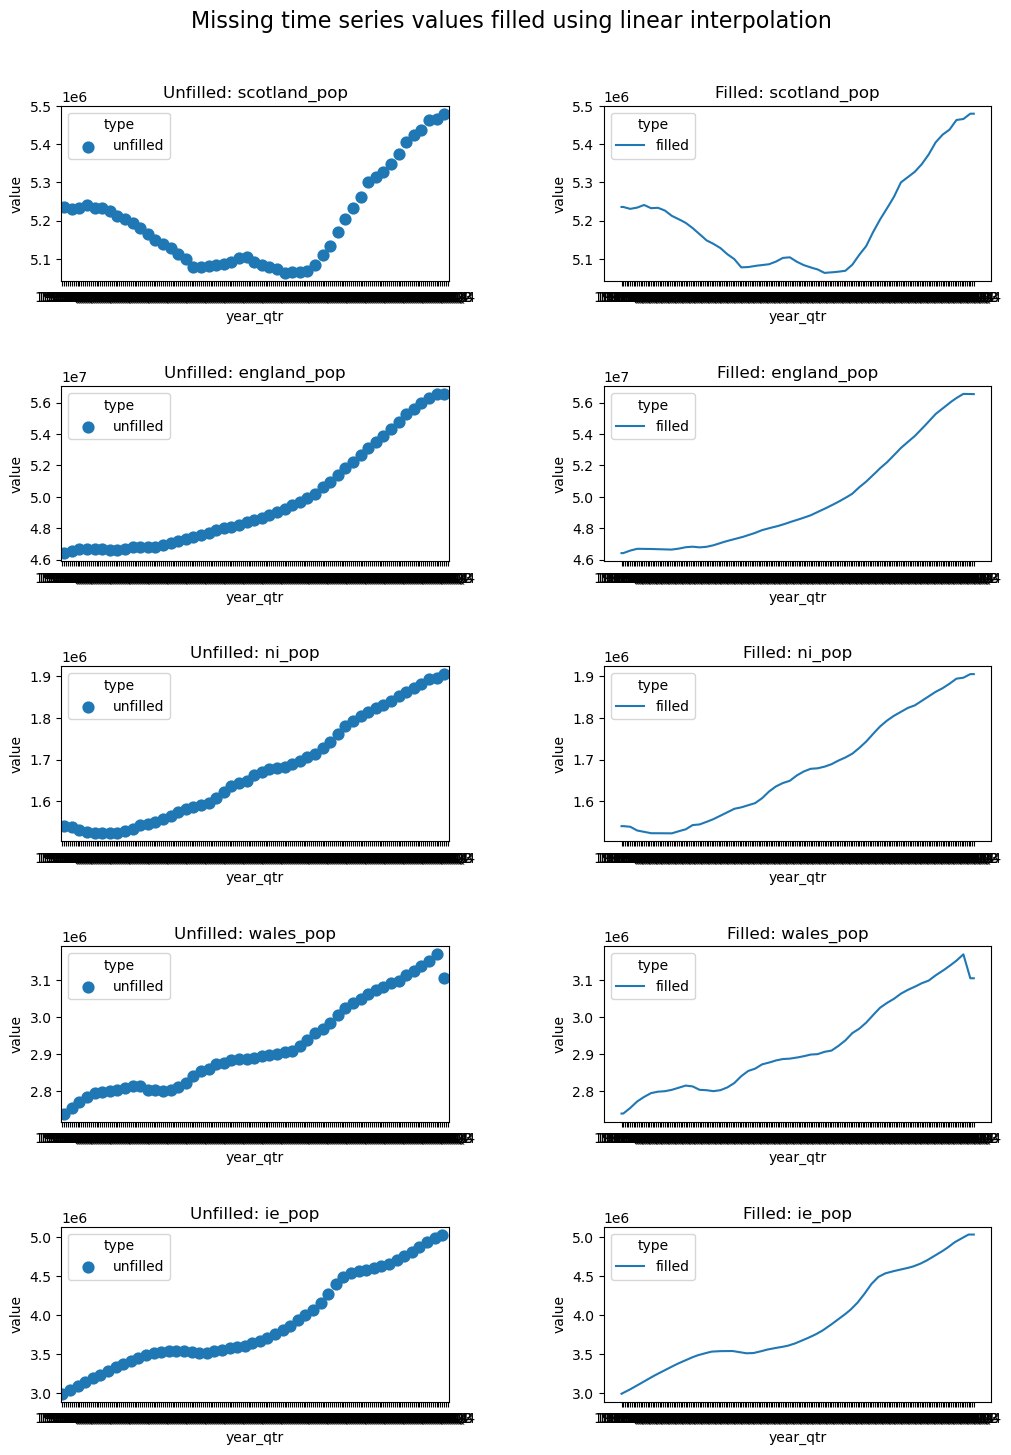

In [194]:
# Create figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

for i, name in enumerate(df_pop_filled_long['variable'].unique()):
    df1, df2 = get_plot_line_comparison_df(df_pop_all_long, df_pop_interpolated_long, ["year_qtr", "variable", "value"], name)
    sns.pointplot(data=df1, x='year_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 0]).set(title="Unfilled: " + name)
    sns.lineplot(data=df2, x='year_qtr', y='value', hue='type', errorbar=None, ax=axs[i, 1]).set(title="Filled: " + name)
fig.suptitle('Missing time series values filled using linear interpolation', fontsize=16)
fig.subplots_adjust(top=0.92, hspace=0.6, wspace=0.4)

# Get sentiment data

In [195]:
# https://github.com/JustAnotherArchivist/snscrape
!pip install snscrape

     ---------------------------------------- 71.8/71.8 kB 2.0 MB/s eta 0:00:00


In [196]:
!pip3 install tweeds

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 69.2/69.2 kB 1.3 MB/s eta 0:00:00
  Created wheel for tweeds: filename=tweeds-2.1.2.3-py3-none-any.whl size=4705 sha256=708a572cf23c923faa3663b561e8607aa5ab6b68db4491acd909053a78d3f224
  Stored in directory: c:\users\emers\appdata\local\pip\cache\wheels\58\97\6e\07d95d8a13e40f02a5e2eeab4229c7edb5aa83974f3569ae49
Successfully built tweeds
  Attempting uninstall: snscrape
    Found existing installation: snscrape 0.6.2.20230320
    Uninstalling snscrape-0.6.2.20230320:
      Successfully uninstalled snscrape-0.6.2.20230320


# Twitter data

In [197]:
# https://chrome.google.com/webstore/detail/instant-data-scraper/ofaokhiedipichpaobibbnahnkdoiiah
# Load the XML file
tweet_files = glob.glob('./datasets/twitter/*.xlsx')

In [198]:
tweet_files

['./datasets/twitter\\twitter (1).xlsx',
 './datasets/twitter\\twitter (2).xlsx',
 './datasets/twitter\\twitter (4).xlsx',
 './datasets/twitter\\twitter (5).xlsx',
 './datasets/twitter\\twitter.xlsx']

In [199]:
list_twitter_dfs = []
for file in tweet_files:
    list_twitter_dfs.append(pd.read_excel(file))

In [200]:
df_twitter_samp = list_twitter_dfs[0].head(50)

In [201]:
df_twitter_samp.head()

,css-4rbku5 href,css-9pa8cd src,css-901oao,css-901oao 2,css-901oao 3,css-4rbku5 href 4,css-4rbku5,css-901oao 4,css-4rbku5 href 5,css-901oao 5,...,css-4rbku5 href 9,css-901oao 10,css-901oao 11,css-4rbku5 href 10,css-901oao 13,css-901oao 14,css-4rbku5 href 11,css-901oao 15,css-4rbku5 9,css-4rbku5 href 15
0,https://twitter.com/Mike_y_San,https://pbs.twimg.com/profile_images/123387640...,EndoftheWorldasWeKnowIt,@Mike_y_San,·,https://twitter.com/Mike_y_San/status/16550157...,May 7,Replying to,https://twitter.com/unionsaustralia,@unionsaustralia,...,https://twitter.com/hashtag/auspol?src=hashtag...,1,1,https://twitter.com/Mike_y_San/status/16550157...,148,NaN,NaN,NaN,NaN,NaN
1,https://twitter.com/writerbyter,https://pbs.twimg.com/profile_images/281408078...,I’m Voting YES—It’s overdue.,@writerbyter,·,https://twitter.com/writerbyter/status/1654988...,May 7,Replying to,https://twitter.com/Crocodylus121,@Crocodylus121,...,NaN,1,3,https://twitter.com/writerbyter/status/1654988...,41,and,https://twitter.com/43a6f0ce5dac4ea,@43a6f0ce5dac4ea,NaN,NaN
2,https://twitter.com/anncherie49,https://pbs.twimg.com/profile_images/122343612...,Ann McGlynn,@anncherie49,·,https://twitter.com/anncherie49/status/1654977...,May 6,NaN,NaN,NaN,...,https://twitter.com/hashtag/auspol?src=hashtag...,1,1,https://twitter.com/anncherie49/status/1654977...,127,NaN,NaN,NaN,NaN,NaN
3,https://twitter.com/SustPopAus,https://pbs.twimg.com/profile_images/725629456...,Sustainable Pop Aus,@SustPopAus,·,https://twitter.com/SustPopAus/status/16549661...,May 6,Replying to,https://twitter.com/WilliamJGoode1,@WilliamJGoode1,...,NaN,1,NaN,https://twitter.com/SustPopAus/status/16549661...,10,NaN,NaN,NaN,NaN,NaN
4,https://twitter.com/unzippedmovie,https://pbs.twimg.com/profile_images/163687166...,UNZIPPED: An Autopsy of American Inequality,@unzippedmovie,·,https://twitter.com/unzippedmovie/status/16549...,May 6,Show this thread,https://twitter.com/unzippedmovie/status/16549...,NaN,...,https://twitter.com/hashtag/documentary?src=ha...,NaN,NaN,https://twitter.com/unzippedmovie/status/16549...,24,NaN,NaN,NaN,#homelessness,https://twitter.com/hashtag/homelessness?src=h...


In [202]:
def parse_twitter_source_file(df):
    list_cols_to_exclude = ["href", "src"]
    print(df.columns)
    list_twitter_cols_to_exclude = [col_name for col_name in df.columns
                                   for exclude_col in list_cols_to_exclude
                                   if str(exclude_col) in str(col_name)]
    print(list_twitter_cols_to_exclude)
    return df.drop(list_twitter_cols_to_exclude, axis=1).iloc[:,3:]

In [203]:
df_twitter_samp = parse_twitter_source_file(df_twitter_samp)
df_twitter_samp.to_csv('./test.csv')

Index(['css-4rbku5 href', 'css-9pa8cd src', 'css-901oao', 'css-901oao 2',
       'css-901oao 3', 'css-4rbku5 href 4', 'css-4rbku5', 'css-901oao 4',
       'css-4rbku5 href 5', 'css-901oao 5', 'css-901oao 6', 'css-4rbku5 2',
       'css-4rbku5 href 6', 'css-901oao 7', 'css-4rbku5 3',
       'css-4rbku5 href 7', 'css-901oao 8', 'css-4rbku5 4',
       'css-4rbku5 href 8', 'css-4rbku5 5', 'css-4rbku5 href 9',
       'css-901oao 10', 'css-901oao 11', 'css-4rbku5 href 10', 'css-901oao 13',
       'css-901oao 14', 'css-4rbku5 href 11', 'css-901oao 15', 'css-4rbku5 9',
       'css-4rbku5 href 15'],
      dtype='object')
['css-4rbku5 href', 'css-9pa8cd src', 'css-4rbku5 href 4', 'css-4rbku5 href 5', 'css-4rbku5 href 6', 'css-4rbku5 href 7', 'css-4rbku5 href 8', 'css-4rbku5 href 9', 'css-4rbku5 href 10', 'css-4rbku5 href 11', 'css-4rbku5 href 15']


In [204]:
date_tag = 'css-4rbku5'
hash_tag = '4rbku5 '
tweet_tag = '901oao'
date_tag_cols = [col_name for col_name in df_twitter_samp.columns
                 if str(date_tag) == str(col_name)]
other_tag_cols = [col_name for col_name in df_twitter_samp.columns
                 if (str(hash_tag) in str(col_name))]
tweet_tag_cols = [col_name for col_name in df_twitter_samp.columns 
                 if ((str(tweet_tag) in str(col_name)) & \
                     ('Replying to' not in str(col_name)) & \
                     ('Show this thread' not in str(col_name)))]

In [205]:
date_tag_cols

['css-4rbku5']

In [206]:
other_tag_cols

['css-4rbku5 2',
 'css-4rbku5 3',
 'css-4rbku5 4',
 'css-4rbku5 5',
 'css-4rbku5 9']

In [207]:
tweet_tag_cols

['css-901oao 4',
 'css-901oao 5',
 'css-901oao 6',
 'css-901oao 7',
 'css-901oao 8',
 'css-901oao 10',
 'css-901oao 11',
 'css-901oao 13',
 'css-901oao 14',
 'css-901oao 15']

In [208]:
df_temp = deepcopy(df_twitter_samp[date_tag_cols])


In [209]:
import math

def concatenate_mentions(row):
    mentions = [str(val) for val in row if '@' in str(val)]
    return ' '.join(mentions)

def concatenate_hashtags(row):
    hashtags = [str(val) for val in row if '#' in str(val)]
    return ' '.join(hashtags)

def concatenate_comments(row):
    comments = [val for val in row if (('Replying to' not in str(val)) & ('Show thread' not in str(val)))]
    comments_parsed = [val for val in comments if not ((isinstance(val, (int, float)) or val is None or (isinstance(val, float) and math.isnan(val))))]

    return ' '.join(comments_parsed)

# Apply the function to each row
df_temp['mentions'] = df_twitter_samp.apply(concatenate_mentions, axis=1)
df_temp['hashtags'] = df_twitter_samp.apply(concatenate_hashtags, axis=1)
df_temp['tweet'] = df_twitter_samp[tweet_tag_cols].apply(concatenate_comments, axis=1)

In [210]:
df_temp

,css-4rbku5,mentions,hashtags,tweet
0,May 7,@unionsaustralia @AustralianLabor,#housingcrisis #healthcare #auspol,"@unionsaustralia What's not fair is 600,000 pe..."
1,May 7,@Crocodylus121 @43a6f0ce5dac4ea,#HousingCrisis #HousingForAll,@Crocodylus121 Hear! Hear! \nIt was revealed t...
2,May 6,,#HousingCrisis #Auspol2023 #auspol,Karen Andrews mouthing about dire state of hou...
3,May 6,@WilliamJGoode1,#HousingCrisis,"@WilliamJGoode1 Yes, we acknowledge there are ..."
4,May 6,@colinkgray,#housingcrisis #unzipped #documentary #homeles...,"Show this thread Full interview Director, host..."
5,May 6,,#HousingCrisis #Vancouver #ClimateCrisis,"Floods to the left of me, wildfires to the rig..."
6,May 6,,#HousingCrisis #SanFranciscoHousing,Show this thread 11/ This tool will provide re...
7,May 6,@Me4Shiva @NForjustice,#HousingCrisis #California #IncreasedCrimes #A...,@Me4Shiva I had few friends visiting from Neth...
8,May 6,,#housingcrisis #KingCharlesCoronation #royals ...,The looks like a giant waste of money. A symbo...
9,May 6,@Southwark_News @Printworks_LDN,#HousingCrisis #southwark #print #housing,@Southwark_News Do people need offices when th...


In [246]:
import pandas as pd
import re

def parse_dataframe(files):
    # Initialize a dictionary to store dataframes
    dfs = {}

    for file in files:
        # Read csv file into dataframe
        df = pd.read_excel(file)

        for column in df.columns:
            # Initialize lists to store extracted data
            rows = []
            comments = []
            hashtags = []
            mentions = []
            dates = []

            # Exclude columns with 'src' or 'href' in the header
            if 'src' not in column and 'href' not in column:
                if 'css-901oao' in column:  # Column contains comment text
                    for text in df[column]:
                        if pd.notna(text):  # Ignore NaN values
                            if not text.isdigit() and 'replying to' not in text.lower() and 'and ' not in text.lower():
                                # Add text to comments
                                comments.append(text)
                elif 'css-4rbku5' in column:  # Column contains hashtags, @mentions or dates
                    for text in df[column]:
                        if pd.notna(text):  # Ignore NaN values
                            # Extract hashtags
                            if '#' in text:
                                hashtags.append(re.findall(r'#[\w\d]+', text))
                            # Extract @ mentions
                            elif '@' in text:
                                mentions.append(re.findall(r'@[\w\d]+', text))
                            # Parse date
                            elif re.match(r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}', text):
                                # Assume the date is in MM/DD/YY format. Adjust according to your date format.
                                date = pd.to_datetime(text, format='%m/%d/%y')
                                # Make sure the year is 2023
                                date = date.replace(year=2023)
                                dates.append(date)
                                
            print(hashtags)
            print("\n")
                                
                                
#         # Create a new dataframe
#         new_df = pd.DataFrame({
#             'comments': [str(comment) for comment in comments],
#             'hashtags': [' '.join([str(hashtag) for hashtag in sub_list]) for sub_list in hashtags],
#             'mentions': [' '.join([str(mention) for mention in sub_list]) for sub_list in mentions],
#             'date': dates
#         })
        
        

        
#         print([str(comment) for comment in comments])
#         print("\n\n")
#         print([' '.join([str(hashtag) for hashtag in sub_list]) for sub_list in hashtags])
#         print("\n\n")
#         print([' '.join([str(mention) for mention in sub_list]) for sub_list in mentions])
        
        
#         # Store the new dataframe in the dictionary
#         dfs[file] = new_df

#     return dfs


In [ ]:
# Removing the Total, YTD, Q1 - Q4 and NaN columns
cols_to_exclude = ['href', 'src']



In [316]:
def find_hashtags(text):
    return re.findall(r'#[\w\d]+', text)

def find_mentions(text):
    return re.findall(r'@[\w\d]+', text)

In [317]:
def process_dataframe(df):
    
    # List comprehension to build a list of columns that contain href or src
    cols_to_exclude = [column for column in df.columns
                   for exclude_col in ['href', 'src']
                   if str(exclude_col) in str(column)]
    
    temp_df = df[['css-4rbku5']]
    cols = cols_to_exclude.append('css-4rbku5')
    
    df = df.drop(cols_to_exclude, axis=1)
    
    temp_df['full_comment'] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    temp_df['hashtags'] = temp_df['full_comment'].apply(find_hashtags)
    temp_df['mentions'] = temp_df['full_comment'].apply(find_mentions)
    
    return temp_df


In [318]:
process_dataframe(pd.read_excel('./datasets/twitter/twitter (1).xlsx'))

In [315]:
a

,css-4rbku5,full_comment
0,May 7,EndoftheWorldasWeKnowIt @Mike_y_San · Replying...
1,May 7,I’m Voting YES—It’s overdue. @writerbyter · Re...
2,May 6,Ann McGlynn @anncherie49 · nan nan Karen Andre...
3,May 6,Sustainable Pop Aus @SustPopAus · Replying to ...
4,May 6,UNZIPPED: An Autopsy of American Inequality @u...
...,...,...
1230,Apr 8,Samatha Anderson @ValleyPSoja · nan nan @KC_RH...
1231,Apr 8,Jerome DICKEY - Richmond City Council Candidat...
1232,Apr 8,Reflection @Panslight · nan nan All new houses...
1233,Apr 8,Anti#FFFGAUSTERITY @watbanner · Replying to @g...


In [308]:
cols = a.append(1)

In [309]:
cols